## structure

Loading and displaying images one after another...


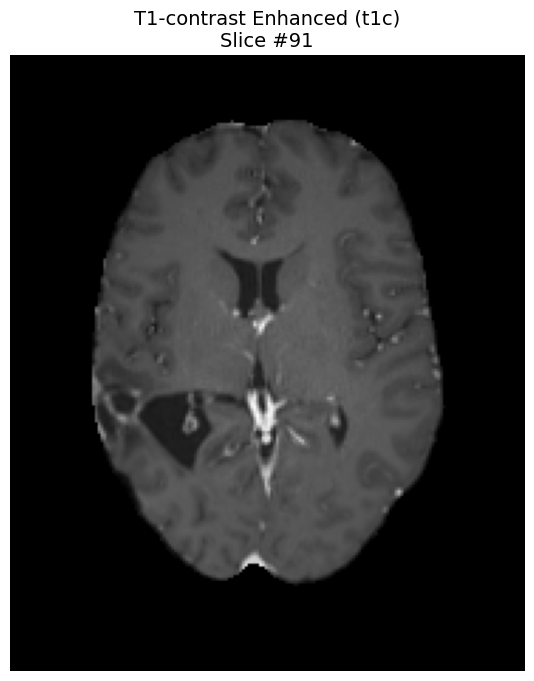

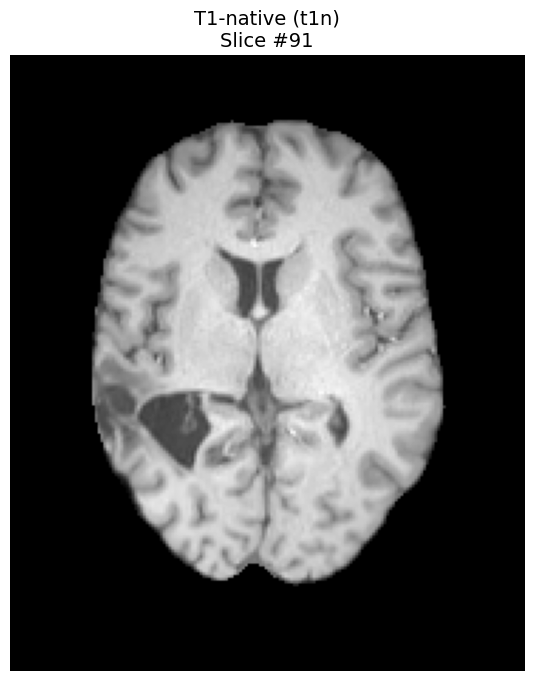

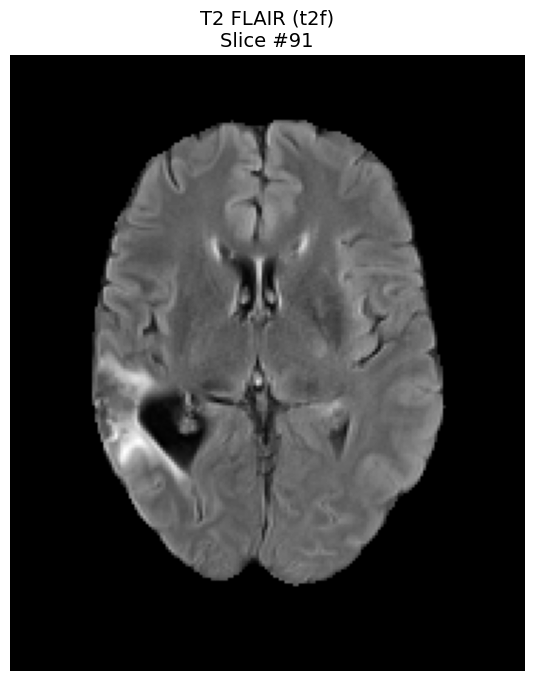

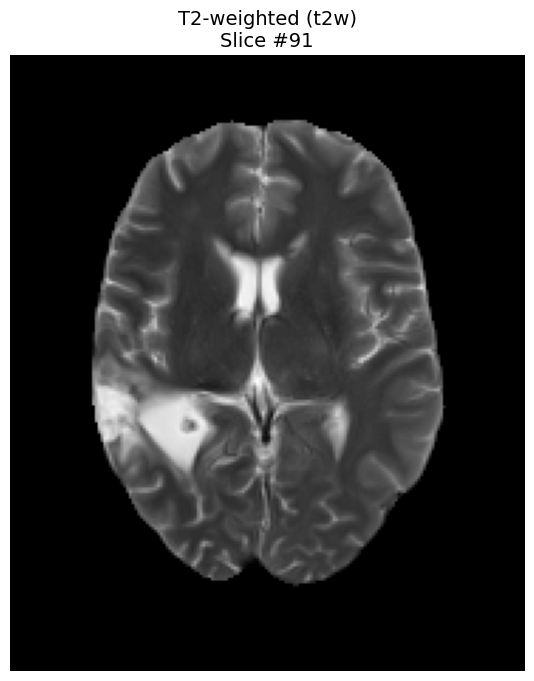

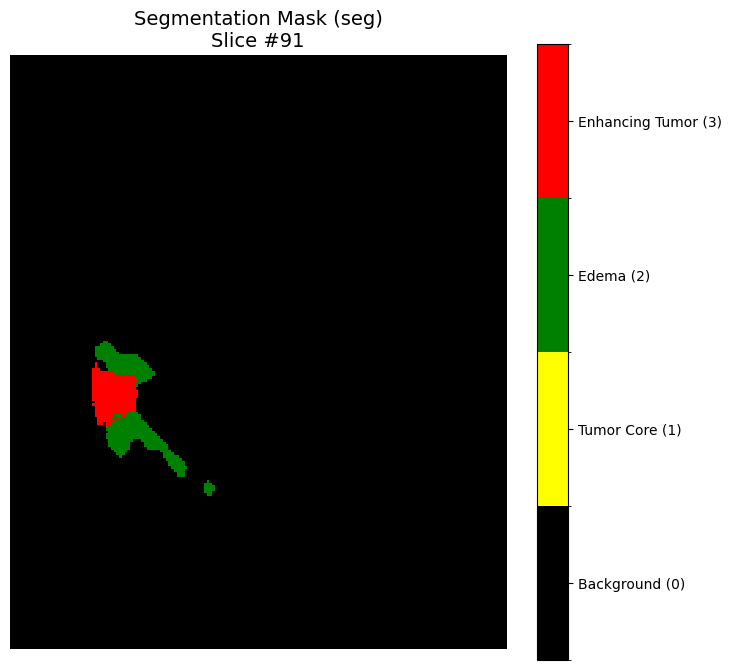

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# --- Step 1: Define the file paths and titles ---

# Base directory for the specific scan
base_path = '/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset/BraTS-GLI-02062-100/'

# The different files to be displayed, including their suffixes and titles
files_to_display = {
    't1c': 'T1-contrast Enhanced (t1c)',
    't1n': 'T1-native (t1n)',
    't2f': 'T2 FLAIR (t2f)',
    't2w': 'T2-weighted (t2w)',
    'seg': 'Segmentation Mask (seg)' # Added the segmentation mask
}

# --- Step 2: Loop through, load, and display each image one by one ---

print("Loading and displaying images one after another...")

try:
    for key, title in files_to_display.items():
        # Construct the full file path for the current image
        file_path = os.path.join(base_path, f'BraTS-GLI-02062-100-{key}.nii')
        
        # Load the NIfTI file
        nifti_image = nib.load(file_path)
        
        # Get the image data as a NumPy array
        image_data = nifti_image.get_fdata()
        
        # Calculate the middle slice index (axial view)
        middle_slice_index = image_data.shape[2] // 2
        
        # Extract the 2D slice
        middle_slice = image_data[:, :, middle_slice_index]
        
        # --- Create a new figure for each plot ---
        plt.figure(figsize=(8, 8))
        ax = plt.gca() # Get current axes
        
        # --- Check if the current file is the segmentation mask ---
        if key == 'seg':
            # Use a special colormap for the segmentation mask
            # BraTS labels: 0=Background, 1=Necrotic Core, 2=Edema, 3=Enhancing Tumor
            cmap = mcolors.ListedColormap(['black', 'yellow', 'green', 'red'])
            bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
            norm = mcolors.BoundaryNorm(bounds, cmap.N)
            
            # Display the mask slice with the special colormap
            im = ax.imshow(middle_slice.T, cmap=cmap, norm=norm, origin='lower', interpolation='nearest')
            
            # Add a color bar to explain the labels
            cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3], spacing='proportional')
            cbar.ax.set_yticklabels(['Background (0)', 'Tumor Core (1)', 'Edema (2)', 'Enhancing Tumor (3)'])
        else:
            # For the regular MRI scans, use a grayscale colormap
            ax.imshow(middle_slice.T, cmap='gray', origin='lower')
            
        ax.set_title(title + f'\nSlice #{middle_slice_index}', fontsize=14)
        ax.axis('off')
        
        # --- Show the plot for the current file before proceeding to the next ---
        plt.show()

except FileNotFoundError as e:
    print(f"ERROR: A file was not found. Please check the path.")
    print(f"File not found: {e.filename}")
    print("\nEnsure you are running this in a Kaggle environment with the 'BraTS2024 small dataset' attached.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

## unsupervised

Total patients found: 200


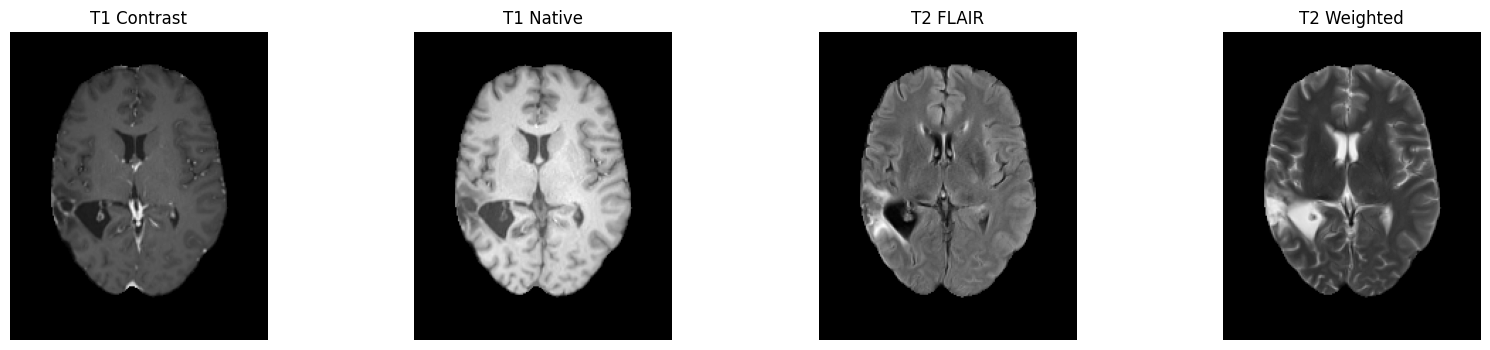

Example slice shape (C,H,W): torch.Size([4, 180, 216])


✅ Epoch [1/5] | Train Loss: 0.148923 | Val Loss: 0.140059


✅ Epoch [2/5] | Train Loss: 0.126037 | Val Loss: 0.107780


✅ Epoch [3/5] | Train Loss: 0.088561 | Val Loss: 0.064975


✅ Epoch [4/5] | Train Loss: 0.045681 | Val Loss: 0.030315


✅ Epoch [5/5] | Train Loss: 0.022229 | Val Loss: 0.016465
✅ Model saved as brats2024_autoencoder_fixed.pth


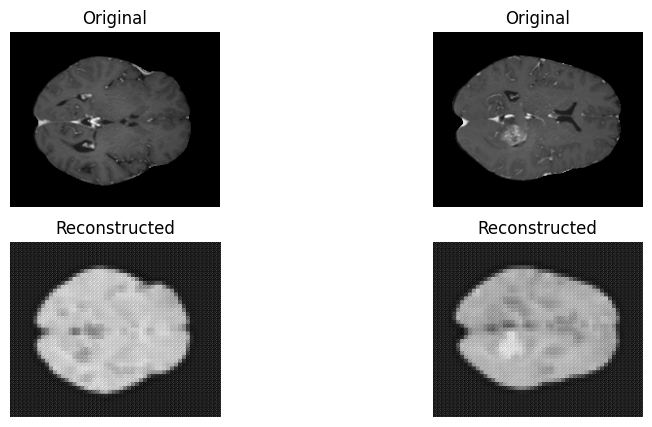

In [43]:
# ==========================
# Corrected full script
# ==========================
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

# ==========================
# 2️⃣ Dataset Path & Structure
# ==========================
BASE_PATH = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"

# Get all patient directories
patients = sorted(glob(os.path.join(BASE_PATH, "BraTS-*")))
print("Total patients found:", len(patients))

# ==========================
# 3️⃣ Visualization Function
# ==========================
def visualize_patient(patient_dir):
    """Visualize 4 MRI modalities for one patient."""
    modalities = ["t1c", "t1n", "t2f", "t2w"]
    titles = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]

    plt.figure(figsize=(20, 4))
    for i, mod in enumerate(modalities):
        file_path = os.path.join(patient_dir, f"{os.path.basename(patient_dir)}-{mod}.nii")
        img = nib.load(file_path).get_fdata()
        mid = img.shape[2] // 2
        slice_ = img[:, :, mid]

        plt.subplot(1, 4, i + 1)
        plt.imshow(slice_.T, cmap="gray", origin='lower')
        plt.title(titles[i])
        plt.axis("off")
    plt.show()

# Visualize one sample patient
visualize_patient(patients[0])

# ==========================
# Helper: crop to multiple of factor (here 4)
# ==========================
def crop_to_multiple(arr, factor=4):
    """
    Crop a 3D numpy array arr (H,W,D) so that H,W,D are multiples of factor.
    Cropping is done from the end (keeps the top-left-front region).
    """
    h, w, d = arr.shape
    new_h = (h // factor) * factor
    new_w = (w // factor) * factor
    new_d = (d // factor) * factor
    return arr[:new_h, :new_w, :new_d]

# ==========================
# 4️⃣ Dataset Class (No Masks) — crops to multiples of 4
# ==========================
class BraTSDataset2D_Unsupervised(Dataset):
    def __init__(self, patient_dirs, factor=4):
        self.patient_dirs = patient_dirs
        self.factor = factor
        self.mods = ["t1c", "t1n", "t2f", "t2w"]

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        imgs = []
        shapes = []

        # Load all modalities and store shapes
        for m in self.mods:
            path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(path).get_fdata()
            # Normalize each modality individually to [0,1]
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
            imgs.append(img)
            shapes.append(img.shape)

        # Align shapes by cropping to smallest shape first (voxel dims)
        min_shape = np.min(np.array(shapes), axis=0).astype(int)
        cropped = [im[:min_shape[0], :min_shape[1], :min_shape[2]] for im in imgs]

        # Crop to multiples of factor (4) so encoding/decoding keeps sizes
        cropped_mult = [crop_to_multiple(im, factor=self.factor) for im in cropped]

        # Stack to [C, H, W, D]
        stacked = np.stack(cropped_mult, axis=0)

        # Take middle slice along depth D
        D = stacked.shape[3]
        mid = D // 2
        img_slice = stacked[:, :, :, mid]  # shape [4, H, W]

        # Convert to float32 tensor and return
        img_tensor = torch.tensor(img_slice, dtype=torch.float32)
        return img_tensor, img_tensor  # input == target (autoencoder)

# ==========================
# 5️⃣ Train/Test Split
# ==========================
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)
train_dataset = BraTSDataset2D_Unsupervised(train_patients)
val_dataset = BraTSDataset2D_Unsupervised(val_patients)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, pin_memory=True)

# print an example shape
sample_img, _ = train_dataset[0]
print("Example slice shape (C,H,W):", sample_img.shape)

# ==========================
# 6️⃣ Define a Simple Autoencoder (keeps shape)
# ==========================
class Autoencoder2D(nn.Module):
    def __init__(self, in_channels=4):
        super(Autoencoder2D, self).__init__()
        # encoder: keep padding=1 so conv preserves dims before pooling
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # H/2, W/2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)   # H/4, W/4
        )
        # decoder: symmetrical to encoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),  # H/2
            nn.ConvTranspose2d(32, in_channels, kernel_size=2, stride=2), nn.Sigmoid()  # H
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# ==========================
# 7️⃣ Training Loop (with safety interpolation)
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder2D(in_channels=4).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    # tqdm progress bar for training
    train_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training", leave=False)
    for imgs, _ in train_bar:
        imgs = imgs.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        if outputs.shape[2:] != imgs.shape[2:]:
            outputs = F.interpolate(outputs, size=imgs.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        avg_loss = train_loss / (len(train_bar) if len(train_bar) > 0 else 1)
        train_bar.set_postfix(loss=f"{avg_loss:.6f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            if outputs.shape[2:] != imgs.shape[2:]:
                outputs = F.interpolate(outputs, size=imgs.shape[2:], mode='bilinear', align_corners=False)
            val_loss += criterion(outputs, imgs).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"✅ Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

# ==========================
# 8️⃣ Save Model
# ==========================
torch.save(model.state_dict(), "brats2024_autoencoder_fixed.pth")
print("✅ Model saved as brats2024_autoencoder_fixed.pth")

# ==========================
# 9️⃣ Visualize Reconstruction (fix plotting to cpu & numpy)
# ==========================
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(val_loader))
    outputs = model(imgs.to(device)).cpu()

imgs = imgs.cpu()
plt.figure(figsize=(10, 5))
n = min(2, imgs.shape[0])
for i in range(n):
    # show first channel (e.g., flair) - channel 0
    plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i][0].numpy(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i][0].numpy(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()


In [44]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np

def psnr(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse + 1e-8))

def batch_ssim(pred_batch, target_batch):
    # pred_batch, target_batch: [B, C, H, W] numpy arrays
    ssim_vals = []
    for i in range(pred_batch.shape[0]):
        # compute SSIM on first channel
        s = ssim(pred_batch[i,0], target_batch[i,0], data_range=pred_batch[i,0].max() - pred_batch[i,0].min())
        ssim_vals.append(s)
    return np.mean(ssim_vals)

# Example usage during validation
model.eval()
psnr_list = []
ssim_list = []

with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        if outputs.shape[2:] != imgs.shape[2:]:
            outputs = F.interpolate(outputs, size=imgs.shape[2:], mode='bilinear', align_corners=False)

        # Convert to numpy
        imgs_np = imgs.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        psnr_val = psnr(outputs, imgs).item()
        ssim_val = batch_ssim(outputs_np, imgs_np)

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)
print(f"Validation PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")


Validation PSNR: 17.8729, SSIM: 0.0990


## UNET

Epoch [1/5] | Train Loss: 0.9337 | Val Loss: 1.1566 | Train Acc: 0.8545 | Val Acc: 0.8813


Epoch [2/5] | Train Loss: 0.6001 | Val Loss: 0.5404 | Train Acc: 0.9711 | Val Acc: 0.9778


Epoch [3/5] | Train Loss: 0.4810 | Val Loss: 0.4300 | Train Acc: 0.9727 | Val Acc: 0.9755


Epoch [4/5] | Train Loss: 0.3859 | Val Loss: 0.3545 | Train Acc: 0.9758 | Val Acc: 0.9780


Epoch [5/5] | Train Loss: 0.3293 | Val Loss: 0.3067 | Train Acc: 0.9747 | Val Acc: 0.9764


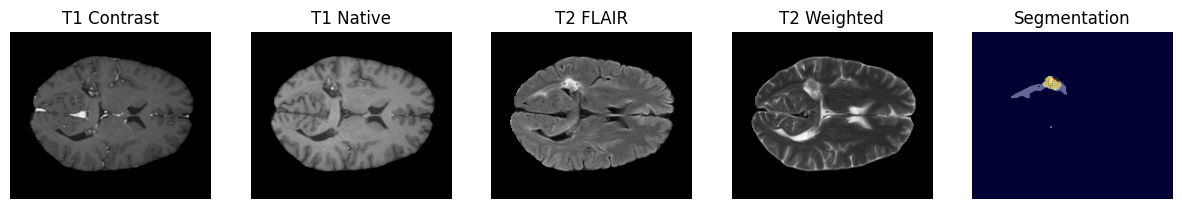

In [4]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==========================
# 1️⃣ Dataset Class
# ==========================
class BraTSDataset2D(Dataset):
    def __init__(self, patient_dirs, slice_axis=2):
        self.patient_dirs = patient_dirs
        self.slice_axis = slice_axis

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        # Load four MRI modalities
        mods = ["t1c", "t1n", "t2f", "t2w"]
        imgs = []
        for m in mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata()
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
            imgs.append(img)

        img = np.stack(imgs, axis=0)  # [4, H, W, D]

        # Load segmentation
        mask_path = os.path.join(pdir, f"{pid}-seg.nii")
        mask = nib.load(mask_path).get_fdata()
        mask[mask == 4] = 3  # 🩹 Fix: map 4→3

        # Use middle slice
        mid = img.shape[3] // 2
        img_slice = img[:, :, :, mid]
        mask_slice = mask[:, :, mid]

        img_tensor = torch.tensor(img_slice, dtype=torch.float32)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.long)
        return img_tensor, mask_tensor


# ==========================
# 2️⃣ U-Net Model
# ==========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet2D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)

    def crop_to_match(self, enc_feat, dec_feat):
        _, _, h, w = dec_feat.size()
        return torchvision.transforms.CenterCrop([h, w])(enc_feat)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bottleneck(self.pool(e2))

        d2 = self.up2(b)
        e2 = self.crop_to_match(e2, d2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e1 = self.crop_to_match(e1, d1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)


# ==========================
# 3️⃣ Load Data
# ==========================
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"  # <-- adjust path
patient_dirs = [os.path.join(root_dir, p) for p in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, p))]

dataset = BraTSDataset2D(patient_dirs)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


# ==========================
# 4️⃣ Training with Progress & Accuracy
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet2D(in_channels=4, out_channels=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def center_crop_tensor(tensor, target_shape):
    """Crop tensor [B,H,W] or [B,C,H,W] to target spatial size."""
    if tensor.dim() == 4:
        _, _, h, w = tensor.shape
    else:
        _, h, w = tensor.shape
    th, tw = target_shape
    top = (h - th) // 2
    left = (w - tw) // 2
    return tensor[..., top:top+th, left:left+tw]

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).float().sum()
    total = torch.numel(masks)
    return correct / total

EPOCHS = 5
for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_loss, train_acc = 0.0, 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training", leave=False)
    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        masks = center_crop_tensor(masks, outputs.shape[2:])
        loss = criterion(outputs, masks)
        acc = pixel_accuracy(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()
        loop.set_postfix(loss=loss.item(), acc=acc.item())

    # ---- VALIDATION ----
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            masks = center_crop_tensor(masks, outputs.shape[2:])
            loss = criterion(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            val_loss += loss.item()
            val_acc += acc.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Train Acc: {train_acc/len(train_loader):.4f} | "
          f"Val Acc: {val_acc/len(val_loader):.4f}")




# ==========================
# 5️⃣ Visualization Example
# ==========================
model.eval()
with torch.no_grad():
    img, mask = dataset[0]
    pred = model(img.unsqueeze(0).to(device))
    pred_class = torch.argmax(pred, dim=1).cpu().squeeze()

plt.figure(figsize=(15, 3))
mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(img[i], cmap='gray')
    plt.title(mods[i])
    plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(mask, cmap='gray')
plt.imshow(pred_class, cmap='jet', alpha=0.4)
plt.title("Segmentation")
plt.axis('off')
plt.show()


In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


Epoch [1/5] | Train Loss: 0.8992 | Val Loss: 0.6981 | Train Acc: 0.8655 | Val Acc: 0.9472


Epoch [2/5] | Train Loss: 0.5790 | Val Loss: 0.5243 | Train Acc: 0.9719 | Val Acc: 0.9685


Epoch [3/5] | Train Loss: 0.4501 | Val Loss: 0.4166 | Train Acc: 0.9748 | Val Acc: 0.9728


Epoch [4/5] | Train Loss: 0.3581 | Val Loss: 0.3596 | Train Acc: 0.9764 | Val Acc: 0.9666


Epoch [5/5] | Train Loss: 0.2887 | Val Loss: 0.2646 | Train Acc: 0.9788 | Val Acc: 0.9774
Model saved to: /kaggle/working/unet2d_brats.pth


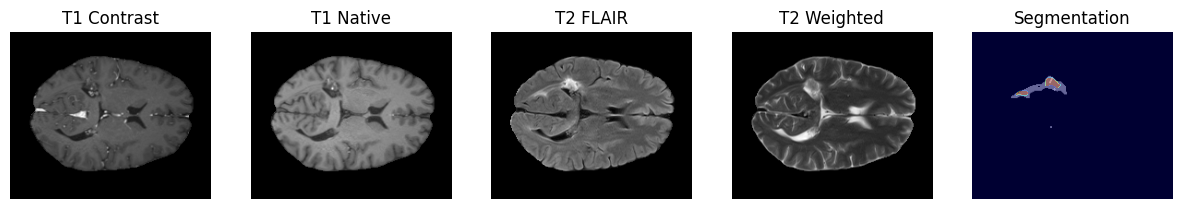

In [2]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==========================
# 1️⃣ Dataset Class
# ==========================
class BraTSDataset2D(Dataset):
    def __init__(self, patient_dirs, slice_axis=2):
        self.patient_dirs = patient_dirs
        self.slice_axis = slice_axis

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        # Load four MRI modalities
        mods = ["t1c", "t1n", "t2f", "t2w"]
        imgs = []
        for m in mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata()
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
            imgs.append(img)

        img = np.stack(imgs, axis=0)  # [4, H, W, D]

        # Load segmentation
        mask_path = os.path.join(pdir, f"{pid}-seg.nii")
        mask = nib.load(mask_path).get_fdata()
        mask[mask == 4] = 3  # 🩹 Fix: map 4→3

        # Use middle slice
        mid = img.shape[3] // 2
        img_slice = img[:, :, :, mid]
        mask_slice = mask[:, :, mid]

        img_tensor = torch.tensor(img_slice, dtype=torch.float32)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.long)
        return img_tensor, mask_tensor


# ==========================
# 2️⃣ U-Net Model
# ==========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet2D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)

    def crop_to_match(self, enc_feat, dec_feat):
        _, _, h, w = dec_feat.size()
        return torchvision.transforms.CenterCrop([h, w])(enc_feat)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bottleneck(self.pool(e2))

        d2 = self.up2(b)
        e2 = self.crop_to_match(e2, d2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e1 = self.crop_to_match(e1, d1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)


# ==========================
# 3️⃣ Load Data
# ==========================
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"  # <-- adjust path
patient_dirs = [os.path.join(root_dir, p) for p in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, p))]

dataset = BraTSDataset2D(patient_dirs)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


# ==========================
# 4️⃣ Training with Progress & Accuracy
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet2D(in_channels=4, out_channels=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def center_crop_tensor(tensor, target_shape):
    """Crop tensor [B,H,W] or [B,C,H,W] to target spatial size."""
    if tensor.dim() == 4:
        _, _, h, w = tensor.shape
    else:
        _, h, w = tensor.shape
    th, tw = target_shape
    top = (h - th) // 2
    left = (w - tw) // 2
    return tensor[..., top:top+th, left:left+tw]

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).float().sum()
    total = torch.numel(masks)
    return correct / total

EPOCHS = 5
for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_loss, train_acc = 0.0, 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training", leave=False)
    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        masks = center_crop_tensor(masks, outputs.shape[2:])
        loss = criterion(outputs, masks)
        acc = pixel_accuracy(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()
        loop.set_postfix(loss=loss.item(), acc=acc.item())

    # ---- VALIDATION ----
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            masks = center_crop_tensor(masks, outputs.shape[2:])
            loss = criterion(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            val_loss += loss.item()
            val_acc += acc.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Train Acc: {train_acc/len(train_loader):.4f} | "
          f"Val Acc: {val_acc/len(val_loader):.4f}")

# ==========================
# 💾 Save Model
# ==========================
save_path = "/kaggle/working/unet2d_brats.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")



# ==========================
# 5️⃣ Visualization Example
# ==========================
model.eval()
with torch.no_grad():
    img, mask = dataset[0]
    pred = model(img.unsqueeze(0).to(device))
    pred_class = torch.argmax(pred, dim=1).cpu().squeeze()

plt.figure(figsize=(15, 3))
mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(img[i], cmap='gray')
    plt.title(mods[i])
    plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(mask, cmap='gray')
plt.imshow(pred_class, cmap='jet', alpha=0.4)
plt.title("Segmentation")
plt.axis('off')
plt.show()


2d+transformer

In [1]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==========================
# 1️⃣ Dataset Class
# ==========================
class BraTSDataset2D(Dataset):
    def __init__(self, patient_dirs, slice_axis=2):
        self.patient_dirs = patient_dirs
        self.slice_axis = slice_axis

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        # Load four MRI modalities
        mods = ["t1c", "t1n", "t2f", "t2w"]
        imgs = []
        for m in mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata()
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
            imgs.append(img)

        img = np.stack(imgs, axis=0)  # [4, H, W, D]

        # Load segmentation
        mask_path = os.path.join(pdir, f"{pid}-seg.nii")
        mask = nib.load(mask_path).get_fdata()
        mask[mask == 4] = 3  # 🩹 Fix: map 4→3

        # Use middle slice
        mid = img.shape[3] // 2
        img_slice = img[:, :, :, mid]
        mask_slice = mask[:, :, mid]

        img_tensor = torch.tensor(img_slice, dtype=torch.float32)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.long)
        return img_tensor, mask_tensor


# ==========================
# 2️⃣ Transformer Block
# ==========================
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )

    def forward(self, x):
        # Flatten spatial dims: (B, C, H, W) → (H*W, B, C)
        b, c, h, w = x.shape
        x_flat = x.flatten(2).permute(2, 0, 1)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x = x_flat + attn_out
        x = self.norm1(x)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        x = x.permute(1, 2, 0).reshape(b, c, h, w)
        return x


# ==========================
# 3️⃣ U-Net + Transformer
# ==========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNetTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(128, 256)
        self.transformer = TransformerBlock(embed_dim=256, num_heads=8)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)

    def crop_to_match(self, enc_feat, dec_feat):
        _, _, h, w = dec_feat.size()
        return torchvision.transforms.CenterCrop([h, w])(enc_feat)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bottleneck(self.pool(e2))
        b = self.transformer(b)
        d2 = self.up2(b)
        e2 = self.crop_to_match(e2, d2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        e1 = self.crop_to_match(e1, d1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ==========================
# 4️⃣ Dice Coefficient
# ==========================
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    dice_total = 0
    num_classes = preds.max() + 1
    for c in range(num_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()
        intersection = (pred_c * target_c).sum()
        dice = (2. * intersection + smooth) / (pred_c.sum() + target_c.sum() + smooth)
        dice_total += dice
    return dice_total / num_classes


# ==========================
# 5️⃣ Data Loading
# ==========================
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
patient_dirs = [os.path.join(root_dir, p) for p in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, p))]

dataset = BraTSDataset2D(patient_dirs)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


# ==========================
# 6️⃣ Training Loop
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetTransformer(in_channels=4, out_channels=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def crop_to_match_shape(preds, masks):
    _, _, h, w = preds.shape
    _, mh, mw = masks.shape
    top = (mh - h) // 2 if mh > h else 0
    left = (mw - w) // 2 if mw > w else 0
    return masks[:, top:top+h, left:left+w]

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    train_loss, train_dice = 0.0, 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training", leave=False)

    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        masks = crop_to_match_shape(outputs, masks)
        loss = criterion(outputs, masks)
        dice = dice_coefficient(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_dice += dice.item()
        loop.set_postfix(loss=loss.item(), dice=dice.item())

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss/len(train_loader):.4f} | Train Dice: {train_dice/len(train_loader):.4f}")

print("✅ Training complete with Transformer and Dice coefficient.")


Epoch [1/10] | Train Loss: 0.9273 | Train Dice: 0.3396


Epoch [2/10] | Train Loss: 0.6036 | Train Dice: 0.4742


Epoch [3/10] | Train Loss: 0.4858 | Train Dice: 0.5812


Epoch [4/10] | Train Loss: 0.3822 | Train Dice: 0.6310


Epoch [5/10] | Train Loss: 0.3115 | Train Dice: 0.6336


Epoch [6/10] | Train Loss: 0.2546 | Train Dice: 0.6561


Epoch [7/10] | Train Loss: 0.2138 | Train Dice: 0.6926


Epoch [8/10] | Train Loss: 0.1764 | Train Dice: 0.7255


Epoch [9/10] | Train Loss: 0.1518 | Train Dice: 0.7314


Epoch [10/10] | Train Loss: 0.1306 | Train Dice: 0.7570
✅ Training complete with Transformer and Dice coefficient.


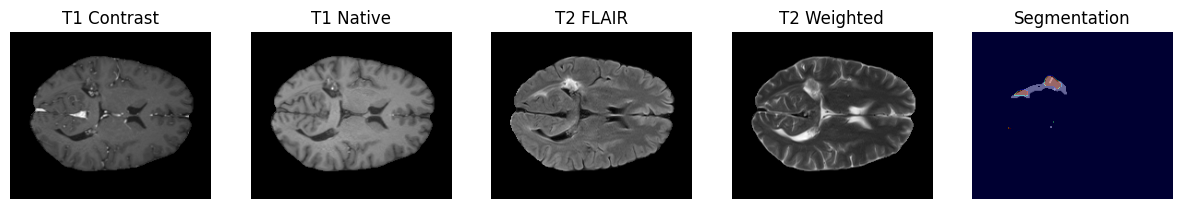

In [2]:
model.eval()
with torch.no_grad():
    img, mask = dataset[0]
    pred = model(img.unsqueeze(0).to(device))
    pred_class = torch.argmax(pred, dim=1).cpu().squeeze()

plt.figure(figsize=(15, 3))
mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(img[i], cmap='gray')
    plt.title(mods[i])
    plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(mask, cmap='gray')
plt.imshow(pred_class, cmap='jet', alpha=0.4)
plt.title("Segmentation")
plt.axis('off')
plt.show()

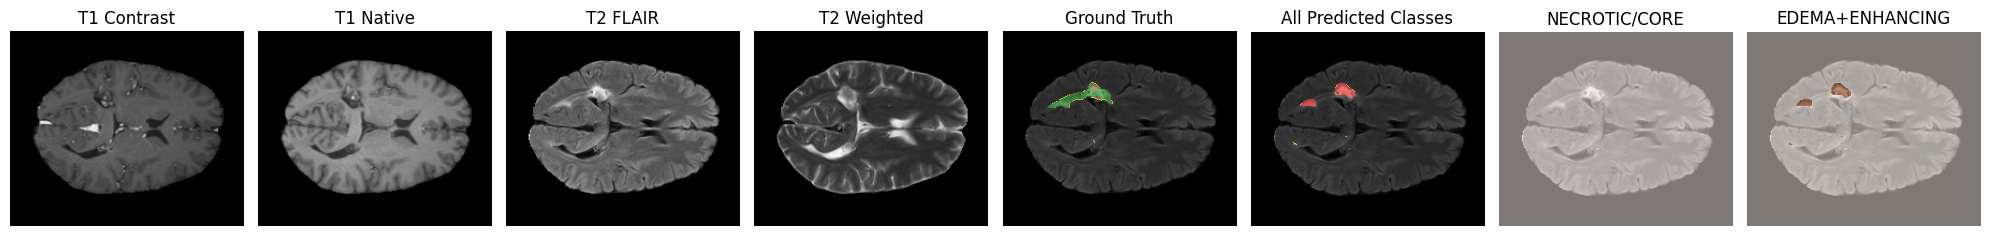

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap

# --- Ensure model is in eval mode ---
model.eval()
with torch.no_grad():
    img, mask = dataset[0]
    img_input = img.unsqueeze(0).to(device)  # [1, 4, H, W]
    pred = model(img_input)
    pred_class = torch.argmax(pred, dim=1).cpu().squeeze(0).numpy()  # [H, W]
    mask_np = mask.numpy()

# --- Define color maps ---
cmap_all = ListedColormap(["black", "yellow", "green", "red"])  # 0=bg, 1,2,3 = tumor classes

# --- Helper function for overlay ---
def overlay_mask_on_image(image, mask, alpha=0.5, cmap=cmap_all):
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, alpha=alpha)
    plt.axis('off')

# --- Modality names ---
mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]

# --- Create Figure ---
plt.figure(figsize=(20, 5))

# 1️⃣ Show 4 modalities
for i in range(4):
    plt.subplot(1, 8, i + 1)
    plt.imshow(img[i], cmap='gray')
    plt.title(mods[i])
    plt.axis('off')

# 2️⃣ Ground Truth
plt.subplot(1, 8, 5)
overlay_mask_on_image(img[2], mask_np, alpha=0.5)
plt.title("Ground Truth")

# 3️⃣ All Predicted Classes
plt.subplot(1, 8, 6)
overlay_mask_on_image(img[2], pred_class, alpha=0.5)
plt.title("All Predicted Classes")

# 4️⃣ Per-class overlays
plt.subplot(1, 8, 7)
overlay_mask_on_image(img[2], (pred_class == 1).astype(float), alpha=0.5, cmap='Reds')
plt.title("NECROTIC/CORE")

plt.subplot(1, 8, 8)
overlay_mask_on_image(img[2], (pred_class == 2).astype(float) + (pred_class == 3).astype(float), alpha=0.5, cmap='Oranges')
plt.title("EDEMA+ENHANCING")

plt.tight_layout()
plt.show()


/tmp/ipykernel_36/568247135.py:163: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch [1/5] Training:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipykernel_36/568247135.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch [1/5] Training: 100%|██████████| 160/160 [14:19<00:00,  5.37s/it]


Epoch 1: Train Loss = 2.1275


Validating:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_36/568247135.py:190: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 40/40 [02:08<00:00,  3.21s/it]


Validation Loss: 1.8803 | Dice Coeff: 0.3302


Epoch [2/5] Training: 100%|██████████| 160/160 [09:24<00:00,  3.53s/it]


Epoch 2: Train Loss = 1.7816


Validating: 100%|██████████| 40/40 [02:46<00:00,  4.15s/it]


Validation Loss: 1.6301 | Dice Coeff: 0.4055


Epoch [3/5] Training: 100%|██████████| 160/160 [08:37<00:00,  3.24s/it]


Epoch 3: Train Loss = 1.5403


Validating: 100%|██████████| 40/40 [02:05<00:00,  3.14s/it]


Validation Loss: 1.4760 | Dice Coeff: 0.5912


Epoch [4/5] Training: 100%|██████████| 160/160 [07:21<00:00,  2.76s/it]


Epoch 4: Train Loss = 1.3386


Validating: 100%|██████████| 40/40 [01:19<00:00,  2.00s/it]


Validation Loss: 1.3075 | Dice Coeff: 0.6045


Epoch [5/5] Training: 100%|██████████| 160/160 [07:25<00:00,  2.79s/it]


Epoch 5: Train Loss = 1.1585


Validating: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


Validation Loss: 1.1243 | Dice Coeff: 0.5845


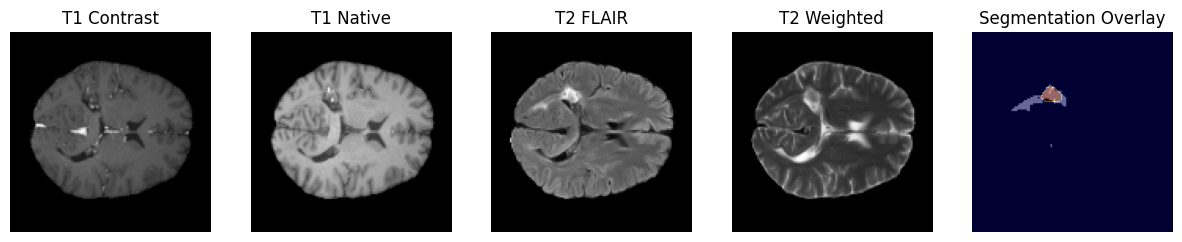

In [1]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ Dataset (3D) with downsampling
# ============================================================
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(128, 128, 64)):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        imgs = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata()
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
            imgs.append(img)
        img = np.stack(imgs, axis=0)  # [4,H,W,D]

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata()
        seg[seg == 4] = 3  # Map 4→3

        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        seg_tensor = torch.tensor(seg, dtype=torch.long).unsqueeze(0).unsqueeze(0).float()

        # 🔽 Downsample to target size
        img_tensor = F.interpolate(img_tensor, size=self.target_size, mode="trilinear", align_corners=False).squeeze(0)
        seg_tensor = F.interpolate(seg_tensor, size=self.target_size, mode="nearest").squeeze(0).long()

        return img_tensor, seg_tensor.squeeze(0)


# ============================================================
# 2️⃣ Transformer Block
# ============================================================
class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B, C, D, H, W = x.shape
        x_flat = x.view(B, C, -1).permute(0, 2, 1)
        x = x_flat + self.attn(self.norm1(x_flat), self.norm1(x_flat), self.norm1(x_flat))[0]
        x = x + self.ffn(self.norm2(x))
        return x.permute(0, 2, 1).view(B, C, D, H, W)


# ============================================================
# 3️⃣ U-Net 3D + Transformer
# ============================================================
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x): return self.conv(x)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ============================================================
# 4️⃣ Dice Loss + Dice Coefficient
# ============================================================
def soft_dice_loss(logits, targets, eps=1e-6):
    num_classes = logits.shape[1]
    probs = torch.softmax(logits, dim=1)
    targets_oh = F.one_hot(targets, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
    dims = (0, 2, 3, 4)
    intersection = torch.sum(probs * targets_oh, dims)
    union = torch.sum(probs + targets_oh, dims)
    dice = (2. * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def dice_coefficient(preds, targets, eps=1e-6):
    preds = torch.argmax(preds, dim=1)
    dice_scores = []
    for cls in range(preds.max()+1):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        inter = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * inter + eps) / (union + eps)
        dice_scores.append(dice.item())
    return np.mean(dice_scores)


# ============================================================
# 5️⃣ Training + Validation + Dice Evaluation
# ============================================================
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
patient_dirs = [os.path.join(root_dir, p) for p in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, p))]
dataset = BraTSDataset3D(patient_dirs)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()

EPOCHS = 5
for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    model.train()
    train_loss = 0.0
    for imgs, segs in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training"):
        imgs, segs = imgs.to(device), segs.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(imgs)
            loss_ce = criterion(logits, segs)
            loss_dice = soft_dice_loss(logits, segs)
            loss = loss_ce + loss_dice
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}")

    # ---------- VALIDATION ----------
    model.eval()
    val_loss, val_dice = 0.0, 0.0
    with torch.no_grad():
        for imgs, segs in tqdm(val_loader, desc="Validating"):
            imgs, segs = imgs.to(device), segs.to(device)
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss_ce = criterion(logits, segs)
                loss_dice = soft_dice_loss(logits, segs)
                loss = loss_ce + loss_dice
            val_loss += loss.item()
            val_dice += dice_coefficient(logits, segs)
    print(f"Validation Loss: {val_loss/len(val_loader):.4f} | Dice Coeff: {val_dice/len(val_loader):.4f}")
    torch.cuda.empty_cache()


# ============================================================
# 6️⃣ Visualization of one case
# ============================================================
model.eval()
with torch.no_grad():
    img, mask = dataset[0]
    img = img.unsqueeze(0).to(device)
    pred = model(img)
    pred_class = torch.argmax(pred, dim=1).cpu().squeeze()

mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]
mid_slice = pred_class.shape[2] // 2

plt.figure(figsize=(15, 3))
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(img[0, i, :, :, mid_slice].cpu(), cmap='gray')
    plt.title(mods[i])
    plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(mask[:, :, mid_slice], cmap='gray')
plt.imshow(pred_class[:, :, mid_slice], cmap='jet', alpha=0.4)
plt.title("Segmentation Overlay")
plt.axis('off')
plt.show()


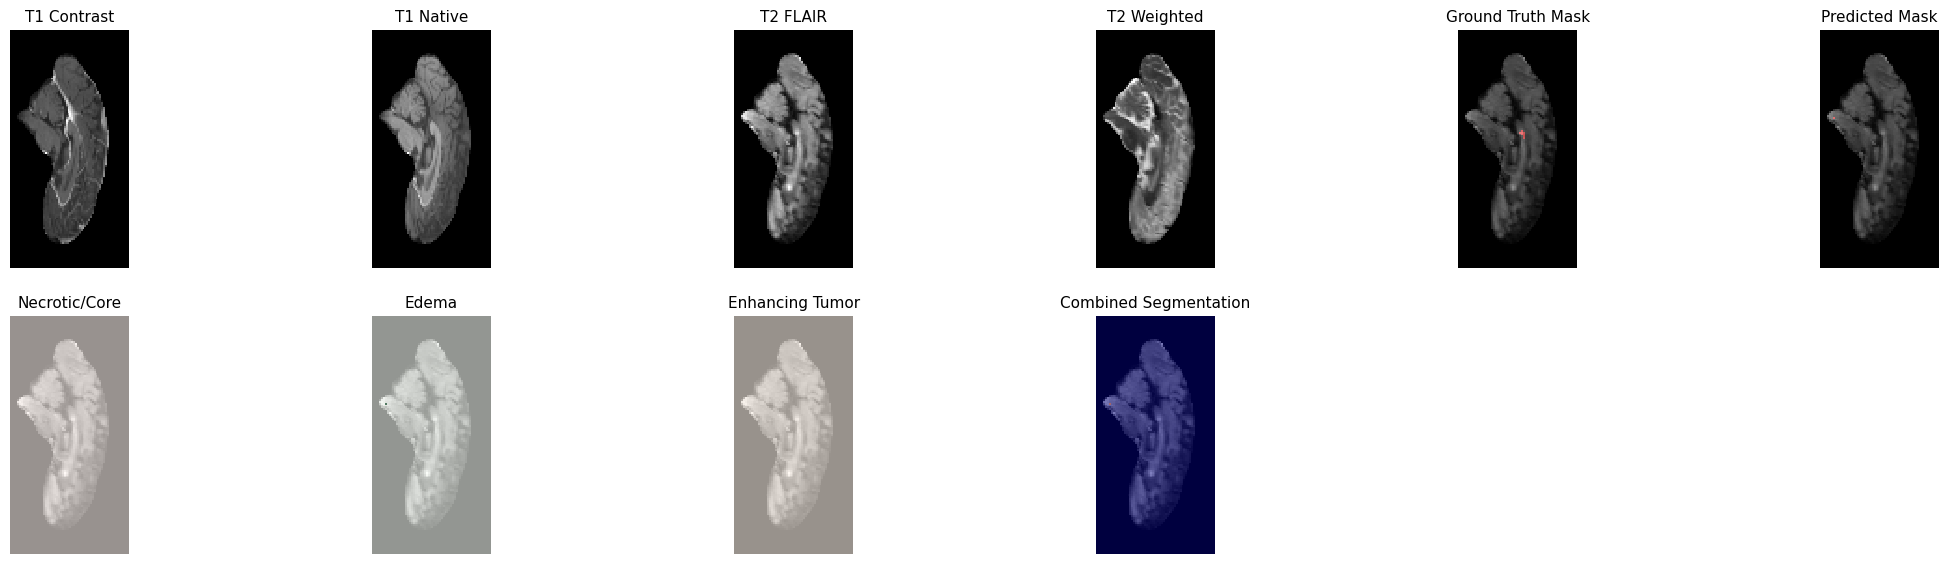

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap

# --- Set model to eval mode ---
model.eval()
with torch.no_grad():
    img, mask = dataset[0]
    img_input = img.unsqueeze(0).to(device)  # [1, 4, D, H, W]
    pred = model(img_input)
    pred_class = torch.argmax(pred, dim=1).cpu().squeeze(0).numpy()  # [D, H, W]
    mask_np = mask.numpy()

# --- Define color map for segmentation ---
cmap_all = ListedColormap(["black", "yellow", "green", "red"])  # bg, 1, 2, 3

# --- Helper function for overlay (crisper visualization) ---
def overlay_mask_on_image(image, mask, alpha=0.4, cmap=cmap_all):
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)  # normalize for display
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.imshow(mask, cmap=cmap, alpha=alpha, interpolation='nearest')
    plt.axis('off')

# --- Modality names ---
mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]

# --- Pick middle slice along depth dimension (axis=1) ---
mid_slice = img.shape[1] // 2

# --- Extract same slice across all modalities ---
img_slice = img[:, mid_slice, :, :].numpy()  # [4, H, W]
mask_slice = mask_np[mid_slice, :, :]         # [H, W]
pred_slice = pred_class[mid_slice, :, :]      # [H, W]

# --- Create Figure ---
plt.figure(figsize=(22, 6))

# 1️⃣ Show 4 modalities clearly
for i in range(4):
    plt.subplot(2, 6, i + 1)
    plt.imshow(img_slice[i], cmap='gray', interpolation='nearest')
    plt.title(mods[i], fontsize=11)
    plt.axis('off')

# 2️⃣ Ground Truth
plt.subplot(2, 6, 5)
overlay_mask_on_image(img_slice[2], mask_slice, alpha=0.45)
plt.title("Ground Truth Mask", fontsize=11)

# 3️⃣ Predicted Segmentation
plt.subplot(2, 6, 6)
overlay_mask_on_image(img_slice[2], pred_slice, alpha=0.45)
plt.title("Predicted Mask", fontsize=11)

# 4️⃣ Per-class overlays (bottom row)
plt.subplot(2, 6, 7)
overlay_mask_on_image(img_slice[2], (pred_slice == 1).astype(float), alpha=0.6, cmap='Reds')
plt.title("Necrotic/Core", fontsize=11)

plt.subplot(2, 6, 8)
overlay_mask_on_image(img_slice[2], (pred_slice == 2).astype(float), alpha=0.6, cmap='Greens')
plt.title("Edema", fontsize=11)

plt.subplot(2, 6, 9)
overlay_mask_on_image(img_slice[2], (pred_slice == 3).astype(float), alpha=0.6, cmap='Oranges')
plt.title("Enhancing Tumor", fontsize=11)

# 5️⃣ Combined view
plt.subplot(2, 6, 10)
overlay_mask_on_image(img_slice[2], ((pred_slice == 1) | (pred_slice == 2) | (pred_slice == 3)).astype(float), alpha=0.5, cmap='jet')
plt.title("Combined Segmentation", fontsize=11)

plt.tight_layout(pad=2)
plt.show()


3d+transformer

In [2]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------------------
# 1) Dataset (fixed shapes + per-modality z-score)
# ---------------------------
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(64,128,128)):  # choose (D,H,W) target
        self.patient_dirs = patient_dirs
        self.target_size = target_size  # (D, H, W)
        # your naming may differ; adapt if files are named differently
        self.mods = ["t1c", "t1n", "t2f", "t2w"]

    def __len__(self):
        return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        # consider non-zero brain voxels only
        mask = vol > 0
        if mask.sum() == 0:
            return vol
        v = vol[mask]
        return_val = (vol - v.mean()) / (v.std() + 1e-8)
        return return_val

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata()  # typically shape (H, W, D)
            img = img.astype(np.float32)
            img = self._zscore_mod(img)
            # reorder to (D, H, W)
            img = np.transpose(img, (2, 0, 1))
            mods.append(img)

        # stack -> (C, D, H, W)
        img = np.stack(mods, axis=0).astype(np.float32)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        # map label 4->3 if needed
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))  # (D, H, W)

        # convert to torch and add batch dim for interpolation
        img_t = torch.from_numpy(img).unsqueeze(0)   # [1, C, D, H, W]
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)  # [1, 1, D, H, W]

        # interpolate to target_size (D, H, W)
        target = tuple(self.target_size)
        img_t = F.interpolate(img_t, size=target, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=target, mode="nearest").long()

        # final shapes: img [C, D, H, W], seg [D, H, W]
        img_t = img_t.squeeze(0)
        seg_t = seg_t.squeeze(0).squeeze(0)

        return img_t, seg_t


# ---------------------------
# 2) TransformerBlock3D (keep as-is, it's fine)
# ---------------------------
class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x: [B, C, D, H, W]
        B, C, D, H, W = x.shape
        x_flat = x.view(B, C, -1).permute(0, 2, 1)  # [B, tokens, C]
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0, 2, 1).view(B, C, D, H, W)


# ---------------------------
# 3) UNet3DTransformer (unchanged, but ensure channels align)
# ---------------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x): return self.conv(x)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ---------------------------
# 4) Dice loss + dice coefficient (fixed)
# ---------------------------
def soft_dice_loss(logits, targets, eps=1e-6):
    # logits: [N, C, D, H, W], targets: [N, D, H, W] (long)
    num_classes = logits.shape[1]
    probs = torch.softmax(logits, dim=1)
    targets_oh = F.one_hot(targets.long(), num_classes=num_classes)  # [N, D, H, W, C]
    targets_oh = targets_oh.permute(0, 4, 1, 2, 3).float()             # [N, C, D, H, W]
    dims = (0, 2, 3, 4)
    intersection = torch.sum(probs * targets_oh, dims)
    union = torch.sum(probs + targets_oh, dims)
    dice = (2. * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()

def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    # logits: [N,C,D,H,W], targets: [N,D,H,W]
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        inter = (pred_cls * target_cls).sum(dim=(1,2,3))  # sum per batch
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter + eps) / (union + eps)).cpu().numpy()
        per_class.append(dice)  # list of arrays (batch,)
    # average over classes then over batch
    per_class = np.stack(per_class, axis=0)  # [C, N]
    mean_over_classes = per_class.mean(axis=0)  # [N]
    return float(mean_over_classes.mean())


# ---------------------------
# 5) Training setup (fixed shapes, amp API, scheduler)
# ---------------------------
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
patient_dirs = [os.path.join(root_dir, p) for p in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, p))]
dataset = BraTSDataset3D(patient_dirs, target_size=(32,128,128))  # example target (D,H,W)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DTransformer().to(device)
criterion = nn.CrossEntropyLoss()   # expects [N,C,D,H,W], targets [N,D,H,W] long
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)

scaler = torch.amp.GradScaler()  # new API

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for imgs, segs in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training"):
        imgs = imgs.to(device)           # [N, C, D, H, W]
        segs = segs.to(device)           # [N, D, H, W]
        optimizer.zero_grad()

        with torch.amp.autocast(device_type=str(device)):
            logits = model(imgs)
            loss_ce = criterion(logits, segs)
            loss_dice = soft_dice_loss(logits, segs)
            loss = loss_ce + loss_dice

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, segs in tqdm(val_loader, desc="Validating"):
            imgs = imgs.to(device)
            segs = segs.to(device)
            with torch.amp.autocast(device_type=str(device)):
                logits = model(imgs)
                loss_ce = criterion(logits, segs)
                loss_dice = soft_dice_loss(logits, segs)
                loss = loss_ce + loss_dice

            val_loss += loss.item()
            val_dice += dice_coefficient(logits, segs, num_classes=4)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f} | Dice Coeff: {avg_val_dice:.4f}")

    scheduler.step(avg_val_loss)   # reduce LR if val loss plateaus
    torch.cuda.empty_cache()


Epoch [1/10] Training: 100%|██████████| 160/160 [04:41<00:00,  1.76s/it]


Epoch 1: Train Loss = 1.6403


Validating: 100%|██████████| 40/40 [01:20<00:00,  2.00s/it]


Validation Loss: 1.6146 | Dice Coeff: 0.5308


Epoch [2/10] Training: 100%|██████████| 160/160 [04:19<00:00,  1.62s/it]


Epoch 2: Train Loss = 1.3643


Validating: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it]


Validation Loss: 1.3551 | Dice Coeff: 0.6338


Epoch [3/10] Training: 100%|██████████| 160/160 [04:47<00:00,  1.80s/it]


Epoch 3: Train Loss = 1.1897


Validating: 100%|██████████| 40/40 [00:34<00:00,  1.18it/s]


Validation Loss: 1.2045 | Dice Coeff: 0.6491


Epoch [4/10] Training: 100%|██████████| 160/160 [04:34<00:00,  1.71s/it]


Epoch 4: Train Loss = 1.0481


Validating: 100%|██████████| 40/40 [01:07<00:00,  1.68s/it]


Validation Loss: 1.0458 | Dice Coeff: 0.6780


Epoch [5/10] Training: 100%|██████████| 160/160 [04:41<00:00,  1.76s/it]


Epoch 5: Train Loss = 0.9466


Validating: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


Validation Loss: 0.9351 | Dice Coeff: 0.7087


Epoch [6/10] Training: 100%|██████████| 160/160 [04:37<00:00,  1.73s/it]


Epoch 6: Train Loss = 0.8716


Validating: 100%|██████████| 40/40 [01:09<00:00,  1.73s/it]


Validation Loss: 0.8806 | Dice Coeff: 0.7025


Epoch [7/10] Training: 100%|██████████| 160/160 [04:43<00:00,  1.77s/it]


Epoch 7: Train Loss = 0.8035


Validating: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


Validation Loss: 0.8156 | Dice Coeff: 0.7212


Epoch [8/10] Training: 100%|██████████| 160/160 [04:39<00:00,  1.75s/it]


Epoch 8: Train Loss = 0.7471


Validating: 100%|██████████| 40/40 [01:10<00:00,  1.76s/it]


Validation Loss: 0.7620 | Dice Coeff: 0.7309


Epoch [9/10] Training: 100%|██████████| 160/160 [04:56<00:00,  1.85s/it]


Epoch 9: Train Loss = 0.6997


Validating: 100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


Validation Loss: 0.7316 | Dice Coeff: 0.7237


Epoch [10/10] Training: 100%|██████████| 160/160 [04:40<00:00,  1.75s/it]


Epoch 10: Train Loss = 0.6559


Validating: 100%|██████████| 40/40 [01:14<00:00,  1.85s/it]

Validation Loss: 0.6817 | Dice Coeff: 0.7491


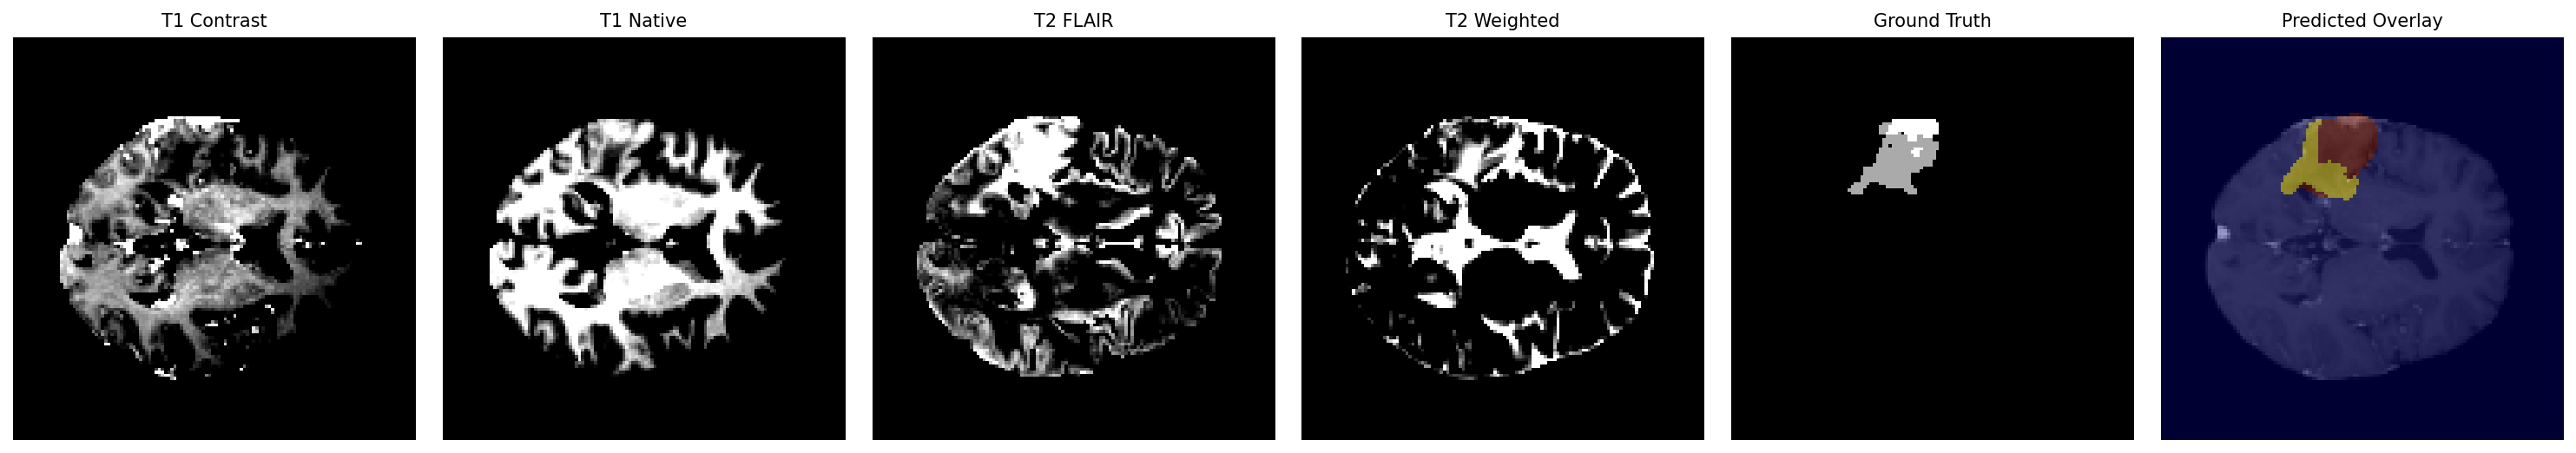

In [5]:
import matplotlib.pyplot as plt
import torch

# Set model to eval mode
model.eval()

# Get one sample from validation dataset
img, mask = val_dataset[0]   # [C, D, H, W], [D, H, W]

# Send to device for prediction
img_in = img.unsqueeze(0).to(device)   # [1, C, D, H, W]

with torch.no_grad(), torch.amp.autocast(device_type=str(device)):
    logits = model(img_in)
    pred = torch.argmax(logits, dim=1).cpu().squeeze(0)  # [D, H, W]

# --- Visualization ---
mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]

# Pick a middle slice from the depth axis
mid_slice = pred.shape[0] // 2

plt.figure(figsize=(20, 4), dpi=150)  # higher DPI for sharper output

# Display modalities
for i in range(4):
    plt.subplot(1, 6, i + 1)
    plt.imshow(img[i, mid_slice, :, :].cpu(), cmap="gray", vmin=0, vmax=1)
    plt.title(mods[i], fontsize=10)
    plt.axis("off")

# Ground Truth
plt.subplot(1, 6, 5)
plt.imshow(mask[mid_slice, :, :].cpu(), cmap="gray")
plt.title("Ground Truth", fontsize=10)
plt.axis("off")

# Predicted Overlay
plt.subplot(1, 6, 6)
plt.imshow(img[0, mid_slice, :, :].cpu(), cmap="gray")
plt.imshow(pred[mid_slice, :, :], cmap="jet", alpha=0.4)
plt.title("Predicted Overlay", fontsize=10)
plt.axis("off")

plt.tight_layout(pad=1.5)
plt.show()



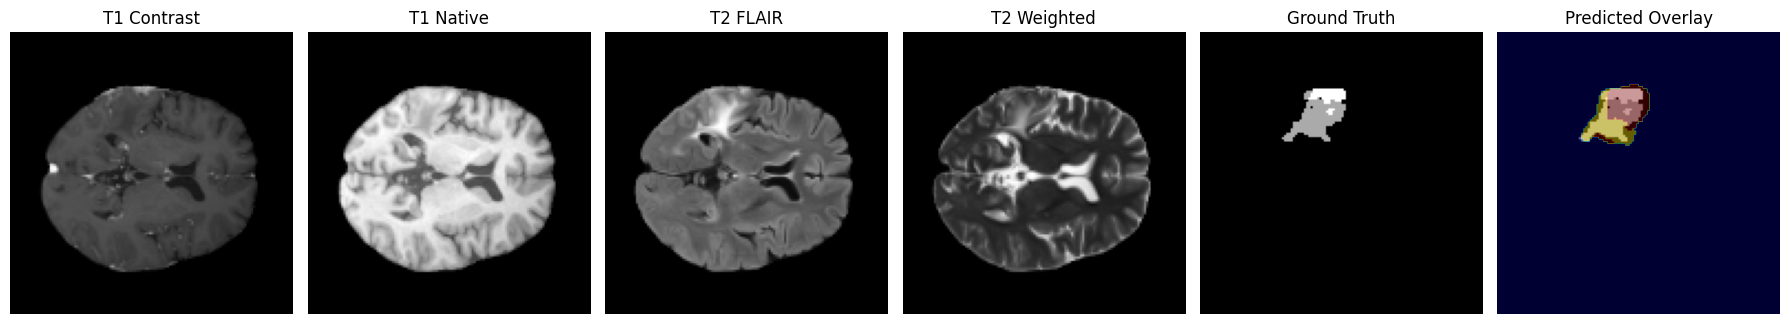

In [6]:
import matplotlib.pyplot as plt
import torch

# Set model to eval mode
model.eval()

# Get one sample from validation dataset
img, mask = val_dataset[0]   # [C, D, H, W], [D, H, W]

# Send to device for prediction
img_in = img.unsqueeze(0).to(device)   # [1, C, D, H, W]

with torch.no_grad(), torch.amp.autocast(device_type=str(device)):
    logits = model(img_in)
    pred = torch.argmax(logits, dim=1).cpu().squeeze(0)  # [D, H, W]

# --- Visualization ---
mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]

# Pick a middle slice from the depth axis
mid_slice = pred.shape[0] // 2

plt.figure(figsize=(18, 4))

# Display all 4 modalities
for i in range(4):
    plt.subplot(1, 6, i + 1)
    plt.imshow(img[i, mid_slice, :, :].cpu(), cmap="gray")
    plt.title(mods[i])
    plt.axis("off")

# Ground truth segmentation
plt.subplot(1, 6, 5)
plt.imshow(mask[mid_slice, :, :].cpu(), cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

# Overlay predicted segmentation
plt.subplot(1, 6, 6)
plt.imshow(mask[mid_slice, :, :].cpu(), cmap="gray")
plt.imshow(pred[mid_slice, :, :], cmap="jet", alpha=0.4)
plt.title("Predicted Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [3]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random
from tqdm import tqdm

# ---------------------------
# 1) Dataset with light augmentation + normalization
# ---------------------------
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(32,128,128), augment=False):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        mask = vol > 0
        if mask.sum() == 0: return vol
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)

    def _augment(self, img, seg):
        # random flip
        if random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
            seg = np.flip(seg, axis=1).copy()
        # random rotation (90 deg)
        k = random.randint(0, 3)
        img = np.rot90(img, k, axes=(2,3)).copy()
        seg = np.rot90(seg, k, axes=(1,2)).copy()
        return img, seg

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = self._zscore_mod(img)
            img = np.transpose(img, (2, 0, 1))  # (D,H,W)
            mods.append(img)
        img = np.stack(mods, axis=0)  # (C,D,H,W)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))  # (D,H,W)

        if self.augment:
            img, seg = self._augment(img, seg)

        # resize
        img_t = torch.from_numpy(img).unsqueeze(0)
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)
        img_t = F.interpolate(img_t, size=self.target_size, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=self.target_size, mode="nearest").long()
        return img_t.squeeze(0), seg_t.squeeze(0).squeeze(0)


# ---------------------------
# 2) 3D UNet + Transformer (GroupNorm)
# ---------------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)


class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B,C,D,H,W = x.shape
        x_flat = x.view(B, C, -1).permute(0,2,1)
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0,2,1).view(B,C,D,H,W)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ---------------------------
# 3) Improved combined loss (weighted CE + classwise Dice)
# ---------------------------
def classwise_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    one_hot = F.one_hot(targets, num_classes).permute(0,4,1,2,3).float()
    dims = (0,2,3,4)
    intersection = torch.sum(probs * one_hot, dims)
    union = torch.sum(probs + one_hot, dims)
    dice = (2*intersection + eps)/(union + eps)
    loss = 1 - dice
    return loss.mean()

def weighted_loss(logits, targets, class_weights):
    ce = F.cross_entropy(logits, targets, weight=class_weights)
    dice = classwise_dice_loss(logits, targets, num_classes=len(class_weights))
    return 0.6*ce + 0.4*dice


# ---------------------------
# 4) Train setup
# ---------------------------
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
patient_dirs = [os.path.join(root_dir,p) for p in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,p))]

dataset = BraTSDataset3D(patient_dirs, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DTransformer().to(device)

# class weights (background smaller)
class_weights = torch.tensor([0.2, 1.0, 1.0, 1.2]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
scaler = torch.amp.GradScaler()

# ---------------------------
# 5) Train loop
# ---------------------------
def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for cls in range(num_classes):
        pred_cls = (preds==cls).float()
        target_cls = (targets==cls).float()
        inter = (pred_cls*target_cls).sum(dim=(1,2,3))
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter+eps)/(union+eps)).cpu().numpy()
        per_class.append(dice)
    return float(np.mean(np.stack(per_class,axis=0).mean(axis=0)))

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs,segs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs,segs = imgs.to(device), segs.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
            logits = model(imgs)
            loss = weighted_loss(logits, segs, class_weights)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    avg_train = total_loss/len(train_loader)

    model.eval()
    val_loss, val_dice = 0, 0
    with torch.no_grad():
        for imgs,segs in tqdm(val_loader, desc="Validating"):
            imgs,segs = imgs.to(device), segs.to(device)
            with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                logits = model(imgs)
                loss = weighted_loss(logits, segs, class_weights)
            val_loss += loss.item()
            val_dice += dice_coefficient(logits, segs)
    avg_val_loss = val_loss/len(val_loader)
    avg_val_dice = val_dice/len(val_loader)
    print(f"Epoch {epoch+1}: Train={avg_train:.4f} | Val={avg_val_loss:.4f} | Dice={avg_val_dice:.4f}")
    scheduler.step(avg_val_loss)
    torch.cuda.empty_cache()


Validating: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


Epoch 1: Train=0.5143 | Val=0.4389 | Dice=0.7088


Validating: 100%|██████████| 40/40 [00:38<00:00,  1.05it/s]


Epoch 2: Train=0.4110 | Val=0.3816 | Dice=0.7281


Validating: 100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


Epoch 3: Train=0.3607 | Val=0.3445 | Dice=0.7404


Validating: 100%|██████████| 40/40 [00:42<00:00,  1.06s/it]


Epoch 4: Train=0.3272 | Val=0.3150 | Dice=0.7690


Validating: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]

Epoch 5: Train=0.3016 | Val=0.2944 | Dice=0.7843


In [4]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random
from tqdm import tqdm

# ---------------------------
# 1) Dataset with light augmentation + normalization
# ---------------------------
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(32,128,128), augment=False):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        mask = vol > 0
        if mask.sum() == 0: return vol
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)

    def _augment(self, img, seg):
        # random flip
        if random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
            seg = np.flip(seg, axis=1).copy()
        # random rotation (90 deg)
        k = random.randint(0, 3)
        img = np.rot90(img, k, axes=(2,3)).copy()
        seg = np.rot90(seg, k, axes=(1,2)).copy()
        return img, seg

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = self._zscore_mod(img)
            img = np.transpose(img, (2, 0, 1))  # (D,H,W)
            mods.append(img)
        img = np.stack(mods, axis=0)  # (C,D,H,W)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))  # (D,H,W)

        if self.augment:
            img, seg = self._augment(img, seg)

        # resize
        img_t = torch.from_numpy(img).unsqueeze(0)
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)
        img_t = F.interpolate(img_t, size=self.target_size, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=self.target_size, mode="nearest").long()
        return img_t.squeeze(0), seg_t.squeeze(0).squeeze(0)


# ---------------------------
# 2) 3D UNet + Transformer (GroupNorm)
# ---------------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)


class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B,C,D,H,W = x.shape
        x_flat = x.view(B, C, -1).permute(0,2,1)
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0,2,1).view(B,C,D,H,W)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ---------------------------
# 3) Improved combined loss (weighted CE + classwise Dice)
# ---------------------------
def classwise_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    one_hot = F.one_hot(targets, num_classes).permute(0,4,1,2,3).float()
    dims = (0,2,3,4)
    intersection = torch.sum(probs * one_hot, dims)
    union = torch.sum(probs + one_hot, dims)
    dice = (2*intersection + eps)/(union + eps)
    loss = 1 - dice
    return loss.mean()

def weighted_loss(logits, targets, class_weights):
    ce = F.cross_entropy(logits, targets, weight=class_weights)
    dice = classwise_dice_loss(logits, targets, num_classes=len(class_weights))
    return 0.6*ce + 0.4*dice


# ---------------------------
# 4) Train setup
# ---------------------------
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
patient_dirs = [os.path.join(root_dir,p) for p in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,p))]

dataset = BraTSDataset3D(patient_dirs, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DTransformer().to(device)

# class weights (background smaller)
class_weights = torch.tensor([0.2, 1.0, 1.0, 1.2]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
scaler = torch.amp.GradScaler()

# ---------------------------
# 5) Train loop
# ---------------------------
def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for cls in range(num_classes):
        pred_cls = (preds==cls).float()
        target_cls = (targets==cls).float()
        inter = (pred_cls*target_cls).sum(dim=(1,2,3))
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter+eps)/(union+eps)).cpu().numpy()
        per_class.append(dice)
    return float(np.mean(np.stack(per_class,axis=0).mean(axis=0)))

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs,segs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs,segs = imgs.to(device), segs.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
            logits = model(imgs)
            loss = weighted_loss(logits, segs, class_weights)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    avg_train = total_loss/len(train_loader)

    model.eval()
    val_loss, val_dice = 0, 0
    with torch.no_grad():
        for imgs,segs in tqdm(val_loader, desc="Validating"):
            imgs,segs = imgs.to(device), segs.to(device)
            with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                logits = model(imgs)
                loss = weighted_loss(logits, segs, class_weights)
            val_loss += loss.item()
            val_dice += dice_coefficient(logits, segs)
    avg_val_loss = val_loss/len(val_loader)
    avg_val_dice = val_dice/len(val_loader)
    print(f"Epoch {epoch+1}: Train={avg_train:.4f} | Val={avg_val_loss:.4f} | Dice={avg_val_dice:.4f}")
    scheduler.step(avg_val_loss)
    torch.cuda.empty_cache()


Validating: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


Epoch 1: Train=0.5883 | Val=0.5069 | Dice=0.6985


Validating: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


Epoch 2: Train=0.4720 | Val=0.4371 | Dice=0.7165


Validating: 100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


Epoch 3: Train=0.4116 | Val=0.3868 | Dice=0.7448


Validating: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


Epoch 4: Train=0.3666 | Val=0.3481 | Dice=0.7538


Validating: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]


Epoch 5: Train=0.3321 | Val=0.3197 | Dice=0.7583


Validating: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]


Epoch 6: Train=0.3054 | Val=0.2964 | Dice=0.7783


Validating: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


Epoch 7: Train=0.2822 | Val=0.2758 | Dice=0.7604


Validating: 100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


Epoch 8: Train=0.2675 | Val=0.2611 | Dice=0.7717


Validating: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it]


Epoch 9: Train=0.2489 | Val=0.2469 | Dice=0.7893


Validating: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]

Epoch 10: Train=0.2417 | Val=0.2388 | Dice=0.8019


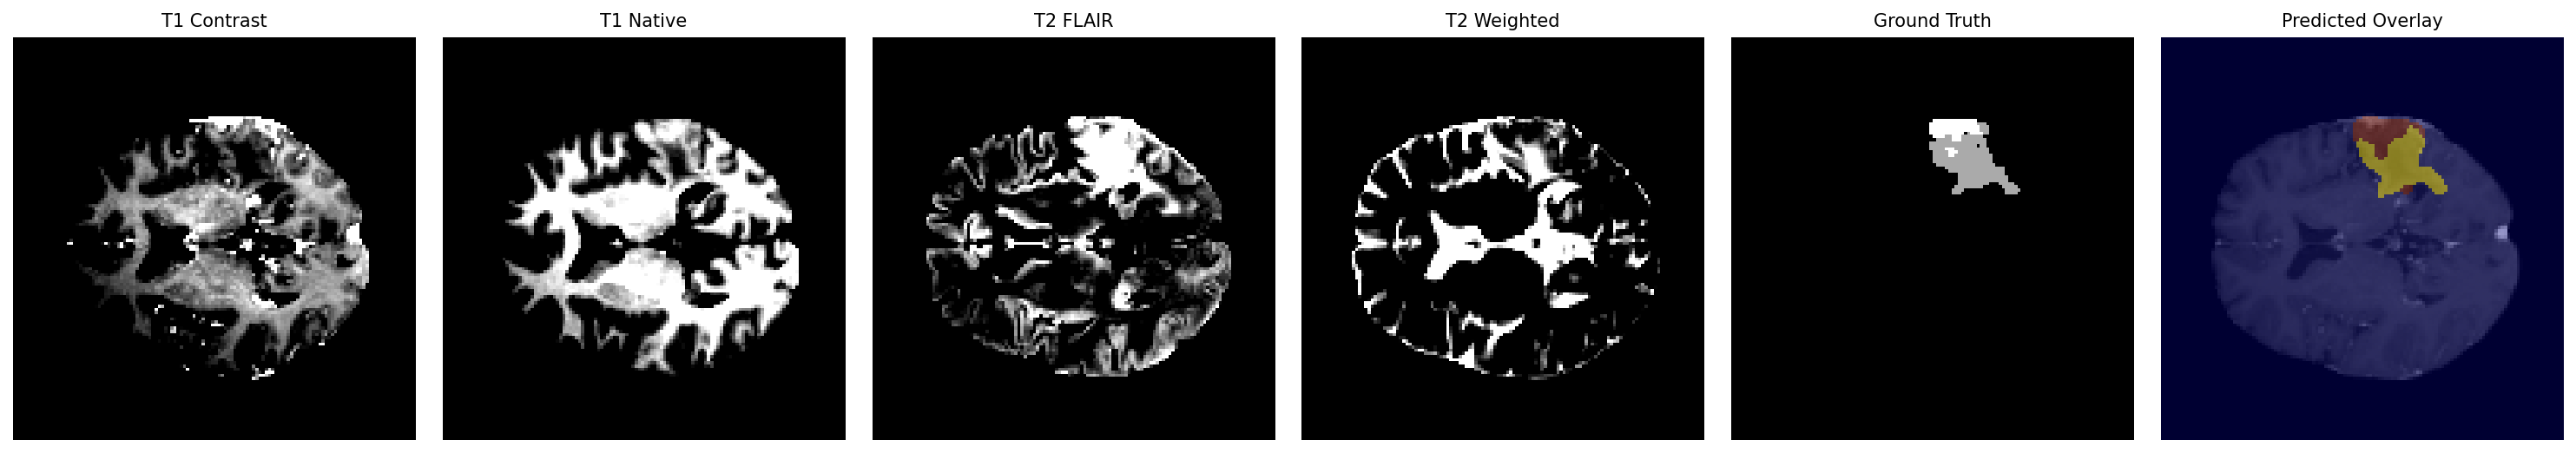

In [5]:
import matplotlib.pyplot as plt
import torch

# Set model to eval mode
model.eval()

# Get one sample from validation dataset
img, mask = val_dataset[0]   # [C, D, H, W], [D, H, W]

# Send to device for prediction
img_in = img.unsqueeze(0).to(device)   # [1, C, D, H, W]

with torch.no_grad(), torch.amp.autocast(device_type=str(device)):
    logits = model(img_in)
    pred = torch.argmax(logits, dim=1).cpu().squeeze(0)  # [D, H, W]

# --- Visualization ---
mods = ["T1 Contrast", "T1 Native", "T2 FLAIR", "T2 Weighted"]

# Pick a middle slice from the depth axis
mid_slice = pred.shape[0] // 2

plt.figure(figsize=(20, 4), dpi=150)  # higher DPI for sharper output

# Display modalities
for i in range(4):
    plt.subplot(1, 6, i + 1)
    plt.imshow(img[i, mid_slice, :, :].cpu(), cmap="gray", vmin=0, vmax=1)
    plt.title(mods[i], fontsize=10)
    plt.axis("off")

# Ground Truth
plt.subplot(1, 6, 5)
plt.imshow(mask[mid_slice, :, :].cpu(), cmap="gray")
plt.title("Ground Truth", fontsize=10)
plt.axis("off")

# Predicted Overlay
plt.subplot(1, 6, 6)
plt.imshow(img[0, mid_slice, :, :].cpu(), cmap="gray")
plt.imshow(pred[mid_slice, :, :], cmap="jet", alpha=0.4)
plt.title("Predicted Overlay", fontsize=10)
plt.axis("off")

plt.tight_layout(pad=1.5)
plt.show()



In [2]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import random

# ======================================================
# 1️⃣ Dataset (Normalization + Light Augmentation)
# ======================================================
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(32,128,128), augment=False):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]
        self.augment = augment

    def __len__(self): return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        mask = vol > 0
        if mask.sum() == 0: return vol
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)

    def _augment(self, img, seg):
        if random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
            seg = np.flip(seg, axis=1).copy()
        k = random.randint(0, 3)
        img = np.rot90(img, k, axes=(2,3)).copy()
        seg = np.rot90(seg, k, axes=(1,2)).copy()
        return img, seg

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = self._zscore_mod(img)
            img = np.transpose(img, (2, 0, 1))
            mods.append(img)
        img = np.stack(mods, axis=0)  # (C,D,H,W)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))

        if self.augment:
            img, seg = self._augment(img, seg)

        img_t = torch.from_numpy(img).unsqueeze(0)
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)
        img_t = F.interpolate(img_t, size=self.target_size, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=self.target_size, mode="nearest").long()

        return img_t.squeeze(0), seg_t.squeeze(0).squeeze(0)


# ======================================================
# 2️⃣ Model (UNet3D + Transformer)
# ======================================================
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B,C,D,H,W = x.shape
        x_flat = x.view(B, C, -1).permute(0,2,1)
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0,2,1).view(B,C,D,H,W)

class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ======================================================
# 3️⃣ Loss & Metrics
# ======================================================
def classwise_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    one_hot = F.one_hot(targets, num_classes).permute(0,4,1,2,3).float()
    dims = (0,2,3,4)
    intersection = torch.sum(probs * one_hot, dims)
    union = torch.sum(probs + one_hot, dims)
    dice = (2*intersection + eps)/(union + eps)
    loss = 1 - dice
    return loss.mean()

def weighted_loss(logits, targets, class_weights):
    ce = F.cross_entropy(logits, targets, weight=class_weights)
    dice = classwise_dice_loss(logits, targets, num_classes=len(class_weights))
    return 0.6*ce + 0.4*dice

def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    preds = torch.argmax(logits, dim=1)
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        inter = (pred_cls * target_cls).sum(dim=(1,2,3))
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter + eps) / (union + eps)).cpu().numpy()
        dice_scores.append(dice)
    return float(np.mean(np.stack(dice_scores, axis=0).mean(axis=0)))

def pixel_accuracy(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = torch.numel(targets)
    return correct / total


# ======================================================
# 4️⃣ Training
# ======================================================
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
patient_dirs = [os.path.join(root_dir, p) for p in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, p))]

dataset = BraTSDataset3D(patient_dirs, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DTransformer().to(device)

class_weights = torch.tensor([0.2, 1.0, 1.0, 1.2]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
scaler = torch.amp.GradScaler('cuda')

best_dice = 0
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, segs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, segs = imgs.to(device), segs.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            logits = model(imgs)
            loss = weighted_loss(logits, segs, class_weights)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    avg_train = total_loss / len(train_loader)

    model.eval()
    val_loss, val_dice, val_acc = 0, 0, 0
    with torch.no_grad(), torch.amp.autocast('cuda'):
        for imgs, segs in tqdm(val_loader, desc="Validating"):
            imgs, segs = imgs.to(device), segs.to(device)
            logits = model(imgs)
            loss = weighted_loss(logits, segs, class_weights)
            val_loss += loss.item()
            val_dice += dice_coefficient(logits, segs)
            val_acc += pixel_accuracy(logits, segs)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    scheduler.step(avg_val_loss)
    print(f"Epoch {epoch+1}: "
          f"Train={avg_train:.4f} | Val={avg_val_loss:.4f} | "
          f"Dice={avg_val_dice:.4f} | Acc={avg_val_acc:.4f}")

    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        torch.save(model.state_dict(), "best_brats3d_transformer.pth")
        print(f"✅ Saved new best model (Dice={best_dice:.4f})")

    torch.cuda.empty_cache()

print(f"\nTraining complete. Best Dice: {best_dice:.4f}")

# ======================================================
# 5️⃣ EXPLAINABLE AI - Grad-CAM for 3D
# ======================================================
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        loss = output[:, class_idx].mean()
        loss.backward()

        weights = self.gradients.mean(dim=(2,3,4), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)
        cam = cam[0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam

def visualize_cam_on_slice(cam, img_slice, title="GradCAM Slice"):
    plt.figure(figsize=(6,6))
    plt.imshow(img_slice, cmap='gray')
    plt.imshow(ndimage.zoom(cam, zoom=img_slice.shape[0]/cam.shape[0]), cmap='jet', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

"""
# Example (run this AFTER training)
model.load_state_dict(torch.load("best_brats3d_transformer.pth", map_location=device))
model.eval()
gradcam = GradCAM3D(model, target_layer=model.enc3)
sample_img, _ = next(iter(val_loader))
sample_img = sample_img.to(device)
cam_map = gradcam.generate_cam(sample_img, class_idx=1)  # e.g., tumor class
mid_slice = sample_img[0,0, sample_img.shape[2]//2].cpu().numpy()
visualize_cam_on_slice(cam_map[cam_map.shape[0]//2], mid_slice, "Tumor Attention Map")
"""


Validating: 100%|██████████| 40/40 [00:42<00:00,  1.06s/it]


Epoch 1: Train=0.5183 | Val=0.4434 | Dice=0.5879 | Acc=0.9903
✅ Saved new best model (Dice=0.5879)


Validating: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


Epoch 2: Train=0.4176 | Val=0.3840 | Dice=0.7423 | Acc=0.9944
✅ Saved new best model (Dice=0.7423)


Validating: 100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


Epoch 3: Train=0.3684 | Val=0.3510 | Dice=0.7366 | Acc=0.9933


Validating: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


Epoch 4: Train=0.3307 | Val=0.3163 | Dice=0.7531 | Acc=0.9937
✅ Saved new best model (Dice=0.7531)


Validating: 100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


Epoch 5: Train=0.2971 | Val=0.2840 | Dice=0.7544 | Acc=0.9935
✅ Saved new best model (Dice=0.7544)

Training complete. Best Dice: 0.7544


'\n# Example (run this AFTER training)\nmodel.load_state_dict(torch.load("best_brats3d_transformer.pth", map_location=device))\nmodel.eval()\ngradcam = GradCAM3D(model, target_layer=model.enc3)\nsample_img, _ = next(iter(val_loader))\nsample_img = sample_img.to(device)\ncam_map = gradcam.generate_cam(sample_img, class_idx=1)  # e.g., tumor class\nmid_slice = sample_img[0,0, sample_img.shape[2]//2].cpu().numpy()\nvisualize_cam_on_slice(cam_map[cam_map.shape[0]//2], mid_slice, "Tumor Attention Map")\n'

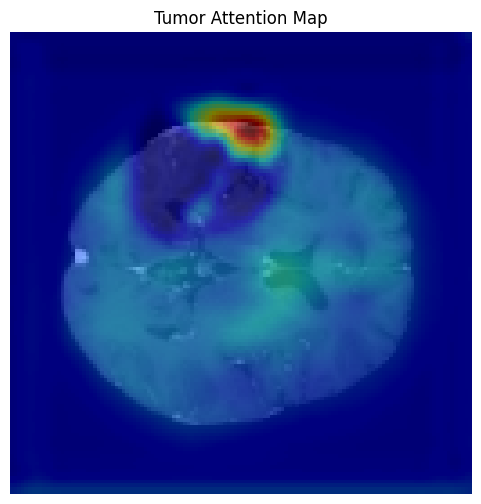

In [3]:
model.load_state_dict(torch.load("best_brats3d_transformer.pth", map_location=device))
model.eval()
gradcam = GradCAM3D(model, target_layer=model.enc3)
sample_img, _ = next(iter(val_loader))
sample_img = sample_img.to(device)
cam_map = gradcam.generate_cam(sample_img, class_idx=1)  # e.g., tumor class
mid_slice = sample_img[0,0, sample_img.shape[2]//2].cpu().numpy()
visualize_cam_on_slice(cam_map[cam_map.shape[0]//2], mid_slice, "Tumor Attention Map")

In [5]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random
from tqdm import tqdm

# ---------------------------
# 1) Dataset with light augmentation + normalization
# ---------------------------
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(32,128,128), augment=False):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        mask = vol > 0
        if mask.sum() == 0: return vol
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)

    def _augment(self, img, seg):
        # random flip
        if random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
            seg = np.flip(seg, axis=1).copy()
        # random rotation (90 deg)
        k = random.randint(0, 3)
        img = np.rot90(img, k, axes=(2,3)).copy()
        seg = np.rot90(seg, k, axes=(1,2)).copy()
        return img, seg

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = self._zscore_mod(img)
            img = np.transpose(img, (2, 0, 1))  # (D,H,W)
            mods.append(img)
        img = np.stack(mods, axis=0)  # (C,D,H,W)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))  # (D,H,W)

        if self.augment:
            img, seg = self._augment(img, seg)

        # resize
        img_t = torch.from_numpy(img).unsqueeze(0)
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)
        img_t = F.interpolate(img_t, size=self.target_size, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=self.target_size, mode="nearest").long()
        return img_t.squeeze(0), seg_t.squeeze(0).squeeze(0)


# ---------------------------
# 2) 3D UNet + Transformer (GroupNorm)
# ---------------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)


class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B,C,D,H,W = x.shape
        x_flat = x.view(B, C, -1).permute(0,2,1)
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0,2,1).view(B,C,D,H,W)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ---------------------------
# 3) Improved combined loss (weighted CE + classwise Dice)
# ---------------------------
def classwise_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    one_hot = F.one_hot(targets, num_classes).permute(0,4,1,2,3).float()
    dims = (0,2,3,4)
    intersection = torch.sum(probs * one_hot, dims)
    union = torch.sum(probs + one_hot, dims)
    dice = (2*intersection + eps)/(union + eps)
    loss = 1 - dice
    return loss.mean()

def weighted_loss(logits, targets, class_weights):
    ce = F.cross_entropy(logits, targets, weight=class_weights)
    dice = classwise_dice_loss(logits, targets, num_classes=len(class_weights))
    return 0.6*ce + 0.4*dice


# ---------------------------
# 4) Train setup
# ---------------------------
root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
patient_dirs = [os.path.join(root_dir,p) for p in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,p))]

dataset = BraTSDataset3D(patient_dirs, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DTransformer().to(device)

# class weights (background smaller)
class_weights = torch.tensor([0.2, 1.0, 1.0, 1.2]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
scaler = torch.amp.GradScaler()

# ---------------------------
# 5) Train loop
# ---------------------------
def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for cls in range(num_classes):
        pred_cls = (preds==cls).float()
        target_cls = (targets==cls).float()
        inter = (pred_cls*target_cls).sum(dim=(1,2,3))
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter+eps)/(union+eps)).cpu().numpy()
        per_class.append(dice)
    return float(np.mean(np.stack(per_class,axis=0).mean(axis=0)))

EPOCHS = 15
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs,segs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs,segs = imgs.to(device), segs.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
            logits = model(imgs)
            loss = weighted_loss(logits, segs, class_weights)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    avg_train = total_loss/len(train_loader)

    model.eval()
    val_loss, val_dice = 0, 0
    with torch.no_grad():
        for imgs,segs in tqdm(val_loader, desc="Validating"):
            imgs,segs = imgs.to(device), segs.to(device)
            with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                logits = model(imgs)
                loss = weighted_loss(logits, segs, class_weights)
            val_loss += loss.item()
            val_dice += dice_coefficient(logits, segs)
    avg_val_loss = val_loss/len(val_loader)
    avg_val_dice = val_dice/len(val_loader)
    print(f"Epoch {epoch+1}: Train={avg_train:.4f} | Val={avg_val_loss:.4f} | Dice={avg_val_dice:.4f}")
    scheduler.step(avg_val_loss)
    torch.cuda.empty_cache()





Validating: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


Epoch 1: Train=0.8210 | Val=0.7121 | Dice=0.5562


Validating: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


Epoch 2: Train=0.6449 | Val=0.5854 | Dice=0.6607


Validating: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Epoch 3: Train=0.5430 | Val=0.5027 | Dice=0.7136


Validating: 100%|██████████| 40/40 [00:45<00:00,  1.15s/it]


Epoch 4: Train=0.4727 | Val=0.4442 | Dice=0.7477


Validating: 100%|██████████| 40/40 [00:48<00:00,  1.20s/it]


Epoch 5: Train=0.4229 | Val=0.4056 | Dice=0.7113


Validating: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


Epoch 6: Train=0.3836 | Val=0.3677 | Dice=0.7634


Validating: 100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


Epoch 7: Train=0.3541 | Val=0.3437 | Dice=0.7505


Validating: 100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


Epoch 8: Train=0.3283 | Val=0.3178 | Dice=0.7713


Validating: 100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


Epoch 9: Train=0.3060 | Val=0.2983 | Dice=0.7777


Validating: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


Epoch 10: Train=0.2863 | Val=0.2811 | Dice=0.7817


Validating: 100%|██████████| 40/40 [00:48<00:00,  1.21s/it]


Epoch 11: Train=0.2697 | Val=0.2640 | Dice=0.7912


Validating: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


Epoch 12: Train=0.2563 | Val=0.2529 | Dice=0.7899


Validating: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it]


Epoch 13: Train=0.2442 | Val=0.2426 | Dice=0.7822


Validating: 100%|██████████| 40/40 [00:58<00:00,  1.45s/it]


Epoch 14: Train=0.2293 | Val=0.2274 | Dice=0.8083


Validating: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]

Epoch 15: Train=0.2189 | Val=0.2216 | Dice=0.7981


Setting up training...

Training model...


Validating: 100%|██████████| 40/40 [00:51<00:00,  1.30s/it]


Epoch 1: Train=0.5846 | Val=0.4871 | Dice=0.6836

Model saved!

Initializing explainability tools...

Generating explanations for a sample...
Generating SHAP explanation...


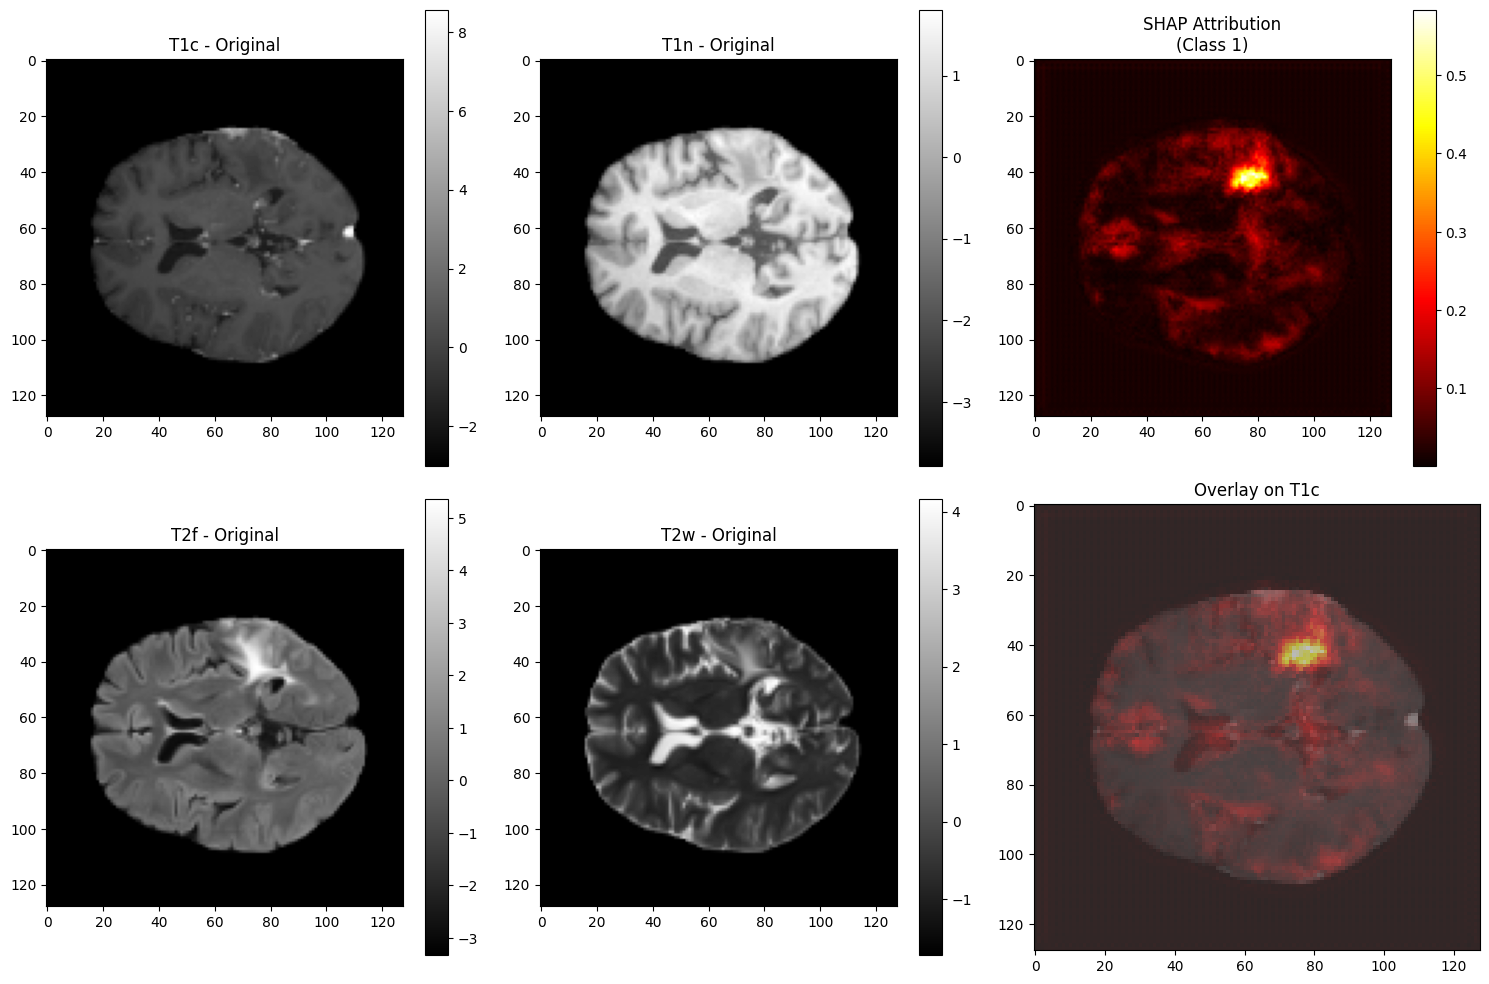

Generating LIME explanation...


ValueError: Only RGB images can be converted to Lab space.

In [8]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# SHAP and LIME imports
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ---------------------------
# 1) Dataset with light augmentation + normalization
# ---------------------------
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(32,128,128), augment=False):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        mask = vol > 0
        if mask.sum() == 0: return vol
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)

    def _augment(self, img, seg):
        if random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
            seg = np.flip(seg, axis=1).copy()
        k = random.randint(0, 3)
        img = np.rot90(img, k, axes=(2,3)).copy()
        seg = np.rot90(seg, k, axes=(1,2)).copy()
        return img, seg

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = self._zscore_mod(img)
            img = np.transpose(img, (2, 0, 1))
            mods.append(img)
        img = np.stack(mods, axis=0)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))

        if self.augment:
            img, seg = self._augment(img, seg)

        img_t = torch.from_numpy(img).unsqueeze(0)
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)
        img_t = F.interpolate(img_t, size=self.target_size, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=self.target_size, mode="nearest").long()
        return img_t.squeeze(0), seg_t.squeeze(0).squeeze(0)


# ---------------------------
# 2) 3D UNet + Transformer
# ---------------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)


class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B,C,D,H,W = x.shape
        x_flat = x.view(B, C, -1).permute(0,2,1)
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0,2,1).view(B,C,D,H,W)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ---------------------------
# 3) Loss functions
# ---------------------------
def classwise_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    one_hot = F.one_hot(targets, num_classes).permute(0,4,1,2,3).float()
    dims = (0,2,3,4)
    intersection = torch.sum(probs * one_hot, dims)
    union = torch.sum(probs + one_hot, dims)
    dice = (2*intersection + eps)/(union + eps)
    loss = 1 - dice
    return loss.mean()

def weighted_loss(logits, targets, class_weights):
    ce = F.cross_entropy(logits, targets, weight=class_weights)
    dice = classwise_dice_loss(logits, targets, num_classes=len(class_weights))
    return 0.6*ce + 0.4*dice


# ---------------------------
# 4) Dice coefficient
# ---------------------------
def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for cls in range(num_classes):
        pred_cls = (preds==cls).float()
        target_cls = (targets==cls).float()
        inter = (pred_cls*target_cls).sum(dim=(1,2,3))
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter+eps)/(union+eps)).cpu().numpy()
        per_class.append(dice)
    return float(np.mean(np.stack(per_class,axis=0).mean(axis=0)))


# ---------------------------
# 5) SHAP Implementation for 3D Medical Images
# ---------------------------
class SHAPExplainer3D:
    def __init__(self, model, device, background_samples=5):
        self.model = model
        self.device = device
        self.background_samples = background_samples
        
    def create_background(self, dataset, num_samples=None):
        """Create background dataset for SHAP"""
        if num_samples is None:
            num_samples = self.background_samples
        
        indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
        backgrounds = []
        for idx in indices:
            img, _ = dataset[idx]
            backgrounds.append(img.unsqueeze(0))
        return torch.cat(backgrounds, dim=0).to(self.device)
    
    def predict_wrapper(self, x):
        """Wrapper for model prediction"""
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
        x = x.to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            probs = torch.softmax(logits, dim=1)
        return probs.cpu().numpy()
    
    def explain_slice(self, image_3d, slice_idx, target_class=1, slice_thickness=8):
        """
        Explain a specific slice using GradientExplainer
        image_3d: (C, D, H, W) tensor
        slice_idx: which depth slice to explain
        target_class: which class to explain (0=background, 1,2,3=tumor regions)
        slice_thickness: number of slices to use (minimum 8 for pooling layers)
        """
        # Extract slice with thickness to avoid pooling issues
        start_idx = max(0, slice_idx - slice_thickness//2)
        end_idx = min(image_3d.shape[1], slice_idx + slice_thickness//2)
        
        # Ensure we have at least slice_thickness slices
        if end_idx - start_idx < slice_thickness:
            end_idx = min(image_3d.shape[1], start_idx + slice_thickness)
            if end_idx - start_idx < slice_thickness:
                start_idx = max(0, end_idx - slice_thickness)
        
        image_slice = image_3d[:, start_idx:end_idx, :, :].unsqueeze(0).to(self.device)
        image_slice.requires_grad = True
        
        # Use gradient-based explanation
        self.model.eval()
        logits = self.model(image_slice)
        
        # Get gradients for target class
        self.model.zero_grad()
        target = logits[:, target_class, :, :, :]
        target.sum().backward()
        
        # Get gradient magnitude as attribution
        gradients = image_slice.grad.abs()
        
        # Extract the center slice from gradients
        center_offset = slice_idx - start_idx
        attributions = gradients[0, :, center_offset, :, :].cpu().numpy()
        
        return attributions
    
    def visualize_shap(self, image_3d, slice_idx, target_class=1, save_path=None):
        """Visualize SHAP explanations"""
        attributions = self.explain_slice(image_3d, slice_idx, target_class)
        
        # Get the actual slice for visualization
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Plot each modality with its attribution
        modalities = ['T1c', 'T1n', 'T2f', 'T2w']
        for i in range(4):
            row = i // 2
            col = i % 2
            
            # Original image
            im = axes[row, col].imshow(img_slice[i], cmap='gray')
            axes[row, col].set_title(f'{modalities[i]} - Original')
            plt.colorbar(im, ax=axes[row, col])
        
        # Attribution heatmap (average across channels)
        attr_avg = np.mean(attributions, axis=0)
        im = axes[0, 2].imshow(attr_avg, cmap='hot')
        axes[0, 2].set_title(f'SHAP Attribution\n(Class {target_class})')
        plt.colorbar(im, ax=axes[0, 2])
        
        # Overlay on first modality
        axes[1, 2].imshow(img_slice[0], cmap='gray', alpha=0.7)
        axes[1, 2].imshow(attr_avg, cmap='hot', alpha=0.5)
        axes[1, 2].set_title('Overlay on T1c')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# ---------------------------
# 6) LIME Implementation for 3D Medical Images
# ---------------------------
class LIMEExplainer3D:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def predict_fn_2d(self, images_2d, depth_context, slice_idx):
        """
        Prediction function for LIME
        images_2d: (N, H, W, C) numpy array - LIME format
        depth_context: the full 3D context
        slice_idx: center slice index
        """
        predictions = []
        slice_thickness = 8
        
        for img_2d in images_2d:
            # img_2d is (H, W, C) where C=4 (modalities)
            img_2d = img_2d.transpose(2, 0, 1)  # (C, H, W)
            
            # Create thick slice by replacing slices around center
            start_idx = max(0, slice_idx - slice_thickness//2)
            end_idx = min(depth_context.shape[1], slice_idx + slice_thickness//2)
            
            # Ensure we have at least slice_thickness slices
            if end_idx - start_idx < slice_thickness:
                end_idx = min(depth_context.shape[1], start_idx + slice_thickness)
                if end_idx - start_idx < slice_thickness:
                    start_idx = max(0, end_idx - slice_thickness)
            
            # Create volume with perturbed slice
            img_3d = depth_context.clone()
            center_offset = slice_idx - start_idx
            img_3d[:, start_idx:end_idx, :, :] = torch.FloatTensor(
                np.tile(img_2d[:, np.newaxis, :, :], (1, end_idx-start_idx, 1, 1))
            )
            
            # Convert to tensor
            img_tensor = img_3d.unsqueeze(0).to(self.device)
            
            self.model.eval()
            with torch.no_grad():
                logits = self.model(img_tensor)
                probs = torch.softmax(logits, dim=1)
                # Average across spatial dimensions
                probs_avg = probs.mean(dim=(2, 3, 4)).cpu().numpy()[0]
            
            predictions.append(probs_avg)
        
        return np.array(predictions)
    
    def explain_slice(self, image_3d, slice_idx, target_class=1, num_samples=100):
        """
        Explain a slice using LIME
        image_3d: (C, D, H, W) tensor
        slice_idx: which depth slice to explain
        target_class: which class to explain
        """
        # Extract slice and convert to LIME format (H, W, C)
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        img_slice_lime = img_slice.transpose(1, 2, 0)  # (H, W, C)
        
        # Normalize to 0-1 for LIME
        img_slice_lime = (img_slice_lime - img_slice_lime.min()) / (img_slice_lime.max() - img_slice_lime.min() + 1e-8)
        
        # Create LIME explainer
        explainer = lime_image.LimeImageExplainer()
        
        # Create prediction function with slice_idx
        pred_fn = lambda x: self.predict_fn_2d(x, image_3d, slice_idx)
        
        # Generate explanation
        explanation = explainer.explain_instance(
            img_slice_lime,
            pred_fn,
            top_labels=4,
            hide_color=0,
            num_samples=num_samples,
            batch_size=10
        )
        
        return explanation
    
    def visualize_lime(self, image_3d, slice_idx, target_class=1, num_samples=100, save_path=None):
        """Visualize LIME explanations"""
        explanation = self.explain_slice(image_3d, slice_idx, target_class, num_samples)
        
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        img_slice_lime = img_slice.transpose(1, 2, 0)
        img_slice_lime = (img_slice_lime - img_slice_lime.min()) / (img_slice_lime.max() - img_slice_lime.min() + 1e-8)
        
        # Get mask for positive and negative features
        temp, mask = explanation.get_image_and_mask(
            target_class, 
            positive_only=True, 
            num_features=10,
            hide_rest=False
        )
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Original modalities
        modalities = ['T1c', 'T1n', 'T2f', 'T2w']
        for i in range(4):
            row = i // 2
            col = i % 2
            axes[row, col].imshow(img_slice[i], cmap='gray')
            axes[row, col].set_title(f'{modalities[i]}')
        
        # LIME explanation
        axes[0, 2].imshow(mark_boundaries(temp, mask))
        axes[0, 2].set_title(f'LIME Explanation\n(Class {target_class})')
        
        # Mask only
        axes[1, 2].imshow(mask, cmap='hot')
        axes[1, 2].set_title('Important Regions')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# ---------------------------
# 7) Training Setup
# ---------------------------
def setup_training():
    root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
    patient_dirs = [os.path.join(root_dir,p) for p in os.listdir(root_dir) 
                    if os.path.isdir(os.path.join(root_dir,p))]

    dataset = BraTSDataset3D(patient_dirs, augment=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet3DTransformer().to(device)

    class_weights = torch.tensor([0.2, 1.0, 1.0, 1.2]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
    scaler = torch.amp.GradScaler('cuda')

    return {
        'model': model,
        'device': device,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'scaler': scaler,
        'class_weights': class_weights,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset
    }


# ---------------------------
# 8) Training Loop
# ---------------------------
def train_model(config, epochs=1):
    model = config['model']
    device = config['device']
    train_loader = config['train_loader']
    val_loader = config['val_loader']
    optimizer = config['optimizer']
    scheduler = config['scheduler']
    scaler = config['scaler']
    class_weights = config['class_weights']
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, segs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, segs = imgs.to(device), segs.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                logits = model(imgs)
                loss = weighted_loss(logits, segs, class_weights)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        avg_train = total_loss / len(train_loader)

        model.eval()
        val_loss, val_dice = 0, 0
        with torch.no_grad():
            for imgs, segs in tqdm(val_loader, desc="Validating"):
                imgs, segs = imgs.to(device), segs.to(device)
                with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                    logits = model(imgs)
                    loss = weighted_loss(logits, segs, class_weights)
                val_loss += loss.item()
                val_dice += dice_coefficient(logits, segs)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        print(f"Epoch {epoch+1}: Train={avg_train:.4f} | Val={avg_val_loss:.4f} | Dice={avg_val_dice:.4f}")
        scheduler.step(avg_val_loss)
        torch.cuda.empty_cache()
    
    return model


# ---------------------------
# 9) Main Execution with Explainability
# ---------------------------
def main():
    # Setup and train
    print("Setting up training...")
    config = setup_training()
    
    print("\nTraining model...")
    trained_model = train_model(config, epochs=1)
    
    # Save model
    torch.save(trained_model.state_dict(), 'unet3d_transformer_brats.pth')
    print("\nModel saved!")
    
    # Initialize explainers
    print("\nInitializing explainability tools...")
    shap_explainer = SHAPExplainer3D(trained_model, config['device'])
    lime_explainer = LIMEExplainer3D(trained_model, config['device'])
    
    # Get a sample for explanation
    print("\nGenerating explanations for a sample...")
    sample_img, sample_seg = config['val_dataset'][0]
    
    # Choose middle slice
    slice_idx = sample_img.shape[1] // 2
    
    # SHAP explanation
    print("Generating SHAP explanation...")
    shap_explainer.visualize_shap(
        sample_img, 
        slice_idx, 
        target_class=1,
        save_path='shap_explanation.png'
    )
    
    # LIME explanation
    print("Generating LIME explanation...")
    lime_explainer.visualize_lime(
        sample_img,
        slice_idx,
        target_class=1,
        num_samples=50,
        save_path='lime_explanation.png'
    )
    
    print("\nExplanations saved!")
    print("- SHAP: shap_explanation.png")
    print("- LIME: lime_explanation.png")
    
    return trained_model, shap_explainer, lime_explainer


# Run the complete pipeline
if __name__ == "__main__":
    model, shap_exp, lime_exp = main()

Setting up training...

Training model...


Validating: 100%|██████████| 40/40 [00:48<00:00,  1.21s/it]


Epoch 1: Train=0.6051 | Val=0.4876 | Dice=0.5984

Model saved!

Initializing explainability tools...

Generating explanations for a sample...
Generating SHAP explanation...


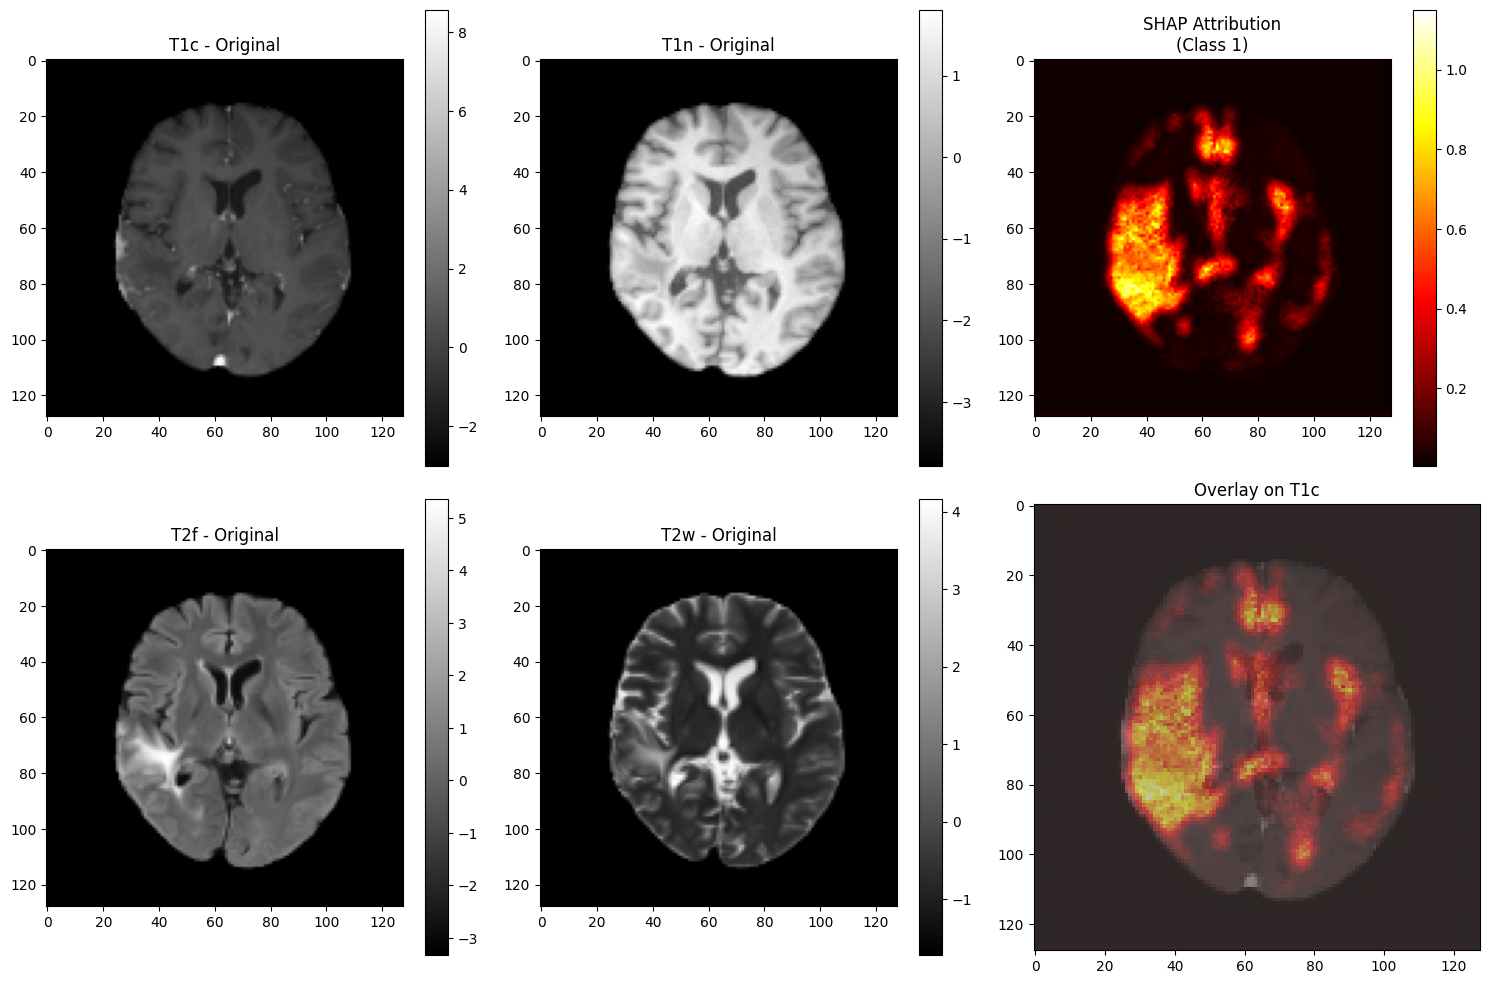

Generating LIME explanation...


  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (539,4)

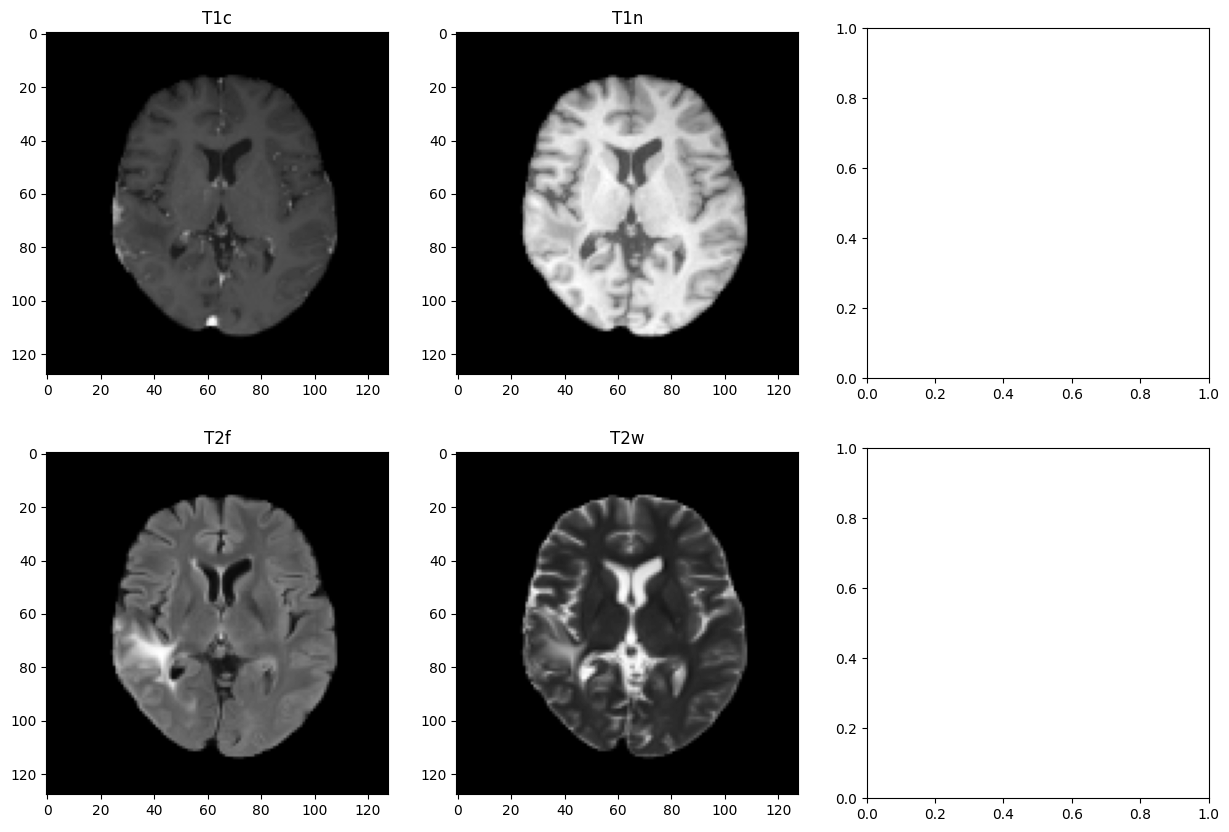

In [9]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# SHAP and LIME imports
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ---------------------------
# 1) Dataset with light augmentation + normalization
# ---------------------------
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(32,128,128), augment=False):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        mask = vol > 0
        if mask.sum() == 0: return vol
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)

    def _augment(self, img, seg):
        if random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
            seg = np.flip(seg, axis=1).copy()
        k = random.randint(0, 3)
        img = np.rot90(img, k, axes=(2,3)).copy()
        seg = np.rot90(seg, k, axes=(1,2)).copy()
        return img, seg

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = self._zscore_mod(img)
            img = np.transpose(img, (2, 0, 1))
            mods.append(img)
        img = np.stack(mods, axis=0)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))

        if self.augment:
            img, seg = self._augment(img, seg)

        img_t = torch.from_numpy(img).unsqueeze(0)
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)
        img_t = F.interpolate(img_t, size=self.target_size, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=self.target_size, mode="nearest").long()
        return img_t.squeeze(0), seg_t.squeeze(0).squeeze(0)


# ---------------------------
# 2) 3D UNet + Transformer
# ---------------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)


class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B,C,D,H,W = x.shape
        x_flat = x.view(B, C, -1).permute(0,2,1)
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0,2,1).view(B,C,D,H,W)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ---------------------------
# 3) Loss functions
# ---------------------------
def classwise_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    one_hot = F.one_hot(targets, num_classes).permute(0,4,1,2,3).float()
    dims = (0,2,3,4)
    intersection = torch.sum(probs * one_hot, dims)
    union = torch.sum(probs + one_hot, dims)
    dice = (2*intersection + eps)/(union + eps)
    loss = 1 - dice
    return loss.mean()

def weighted_loss(logits, targets, class_weights):
    ce = F.cross_entropy(logits, targets, weight=class_weights)
    dice = classwise_dice_loss(logits, targets, num_classes=len(class_weights))
    return 0.6*ce + 0.4*dice


# ---------------------------
# 4) Dice coefficient
# ---------------------------
def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for cls in range(num_classes):
        pred_cls = (preds==cls).float()
        target_cls = (targets==cls).float()
        inter = (pred_cls*target_cls).sum(dim=(1,2,3))
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter+eps)/(union+eps)).cpu().numpy()
        per_class.append(dice)
    return float(np.mean(np.stack(per_class,axis=0).mean(axis=0)))


# ---------------------------
# 5) SHAP Implementation for 3D Medical Images
# ---------------------------
class SHAPExplainer3D:
    def __init__(self, model, device, background_samples=5):
        self.model = model
        self.device = device
        self.background_samples = background_samples
        
    def create_background(self, dataset, num_samples=None):
        """Create background dataset for SHAP"""
        if num_samples is None:
            num_samples = self.background_samples
        
        indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
        backgrounds = []
        for idx in indices:
            img, _ = dataset[idx]
            backgrounds.append(img.unsqueeze(0))
        return torch.cat(backgrounds, dim=0).to(self.device)
    
    def predict_wrapper(self, x):
        """Wrapper for model prediction"""
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
        x = x.to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            probs = torch.softmax(logits, dim=1)
        return probs.cpu().numpy()
    
    def explain_slice(self, image_3d, slice_idx, target_class=1, slice_thickness=8):
        """
        Explain a specific slice using GradientExplainer
        image_3d: (C, D, H, W) tensor
        slice_idx: which depth slice to explain
        target_class: which class to explain (0=background, 1,2,3=tumor regions)
        slice_thickness: number of slices to use (minimum 8 for pooling layers)
        """
        # Extract slice with thickness to avoid pooling issues
        start_idx = max(0, slice_idx - slice_thickness//2)
        end_idx = min(image_3d.shape[1], slice_idx + slice_thickness//2)
        
        # Ensure we have at least slice_thickness slices
        if end_idx - start_idx < slice_thickness:
            end_idx = min(image_3d.shape[1], start_idx + slice_thickness)
            if end_idx - start_idx < slice_thickness:
                start_idx = max(0, end_idx - slice_thickness)
        
        image_slice = image_3d[:, start_idx:end_idx, :, :].unsqueeze(0).to(self.device)
        image_slice.requires_grad = True
        
        # Use gradient-based explanation
        self.model.eval()
        logits = self.model(image_slice)
        
        # Get gradients for target class
        self.model.zero_grad()
        target = logits[:, target_class, :, :, :]
        target.sum().backward()
        
        # Get gradient magnitude as attribution
        gradients = image_slice.grad.abs()
        
        # Extract the center slice from gradients
        center_offset = slice_idx - start_idx
        attributions = gradients[0, :, center_offset, :, :].cpu().numpy()
        
        return attributions
    
    def visualize_shap(self, image_3d, slice_idx, target_class=1, save_path=None):
        """Visualize SHAP explanations"""
        attributions = self.explain_slice(image_3d, slice_idx, target_class)
        
        # Get the actual slice for visualization
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Plot each modality with its attribution
        modalities = ['T1c', 'T1n', 'T2f', 'T2w']
        for i in range(4):
            row = i // 2
            col = i % 2
            
            # Original image
            im = axes[row, col].imshow(img_slice[i], cmap='gray')
            axes[row, col].set_title(f'{modalities[i]} - Original')
            plt.colorbar(im, ax=axes[row, col])
        
        # Attribution heatmap (average across channels)
        attr_avg = np.mean(attributions, axis=0)
        im = axes[0, 2].imshow(attr_avg, cmap='hot')
        axes[0, 2].set_title(f'SHAP Attribution\n(Class {target_class})')
        plt.colorbar(im, ax=axes[0, 2])
        
        # Overlay on first modality
        axes[1, 2].imshow(img_slice[0], cmap='gray', alpha=0.7)
        axes[1, 2].imshow(attr_avg, cmap='hot', alpha=0.5)
        axes[1, 2].set_title('Overlay on T1c')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# ---------------------------
# 6) LIME Implementation for 3D Medical Images
# ---------------------------
class LIMEExplainer3D:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def predict_fn_2d(self, images_2d, depth_context, slice_idx):
        """
        Prediction function for LIME
        images_2d: (N, H, W, C) numpy array - LIME format
        depth_context: the full 3D context
        slice_idx: center slice index
        """
        predictions = []
        slice_thickness = 8
        
        for img_2d in images_2d:
            # img_2d is (H, W, C) where C=4 (modalities)
            img_2d = img_2d.transpose(2, 0, 1)  # (C, H, W)
            
            # Create thick slice by replacing slices around center
            start_idx = max(0, slice_idx - slice_thickness//2)
            end_idx = min(depth_context.shape[1], slice_idx + slice_thickness//2)
            
            # Ensure we have at least slice_thickness slices
            if end_idx - start_idx < slice_thickness:
                end_idx = min(depth_context.shape[1], start_idx + slice_thickness)
                if end_idx - start_idx < slice_thickness:
                    start_idx = max(0, end_idx - slice_thickness)
            
            # Create volume with perturbed slice
            img_3d = depth_context.clone()
            center_offset = slice_idx - start_idx
            img_3d[:, start_idx:end_idx, :, :] = torch.FloatTensor(
                np.tile(img_2d[:, np.newaxis, :, :], (1, end_idx-start_idx, 1, 1))
            )
            
            # Convert to tensor
            img_tensor = img_3d.unsqueeze(0).to(self.device)
            
            self.model.eval()
            with torch.no_grad():
                logits = self.model(img_tensor)
                probs = torch.softmax(logits, dim=1)
                # Average across spatial dimensions
                probs_avg = probs.mean(dim=(2, 3, 4)).cpu().numpy()[0]
            
            predictions.append(probs_avg)
        
        return np.array(predictions)
    
    def explain_slice(self, image_3d, slice_idx, target_class=1, num_samples=100):
        """
        Explain a slice using LIME
        image_3d: (C, D, H, W) tensor
        slice_idx: which depth slice to explain
        target_class: which class to explain
        """
        from skimage.segmentation import slic
        
        # Extract slice and convert to LIME format (H, W, C)
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        img_slice_lime = img_slice.transpose(1, 2, 0)  # (H, W, C)
        
        # Normalize to 0-1 for LIME
        img_slice_lime = (img_slice_lime - img_slice_lime.min()) / (img_slice_lime.max() - img_slice_lime.min() + 1e-8)
        
        # Custom segmentation function for 4-channel images
        def segmentation_fn(image):
            """SLIC segmentation that works with 4 channels"""
            # Use first channel for segmentation, or average if needed
            if image.ndim == 3 and image.shape[2] > 3:
                # For multi-channel medical images, use average or first channel
                image_for_seg = np.mean(image, axis=2)
            else:
                image_for_seg = image
            
            # Apply SLIC segmentation
            segments = slic(image_for_seg, n_segments=50, compactness=10, sigma=1, 
                           start_label=0, channel_axis=None)
            return segments
        
        # Create LIME explainer
        explainer = lime_image.LimeImageExplainer()
        
        # Create prediction function with slice_idx
        pred_fn = lambda x: self.predict_fn_2d(x, image_3d, slice_idx)
        
        # Generate explanation with custom segmentation
        explanation = explainer.explain_instance(
            img_slice_lime,
            pred_fn,
            top_labels=4,
            hide_color=0,
            num_samples=num_samples,
            batch_size=10,
            segmentation_fn=segmentation_fn
        )
        
        return explanation
    
    def visualize_lime(self, image_3d, slice_idx, target_class=1, num_samples=100, save_path=None):
        """Visualize LIME explanations"""
        explanation = self.explain_slice(image_3d, slice_idx, target_class, num_samples)
        
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        img_slice_lime = img_slice.transpose(1, 2, 0)
        img_slice_lime = (img_slice_lime - img_slice_lime.min()) / (img_slice_lime.max() - img_slice_lime.min() + 1e-8)
        
        # Get mask for positive and negative features
        temp, mask = explanation.get_image_and_mask(
            target_class, 
            positive_only=True, 
            num_features=10,
            hide_rest=False
        )
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Original modalities
        modalities = ['T1c', 'T1n', 'T2f', 'T2w']
        for i in range(4):
            row = i // 2
            col = i % 2
            axes[row, col].imshow(img_slice[i], cmap='gray')
            axes[row, col].set_title(f'{modalities[i]}')
        
        # LIME explanation
        axes[0, 2].imshow(mark_boundaries(temp, mask))
        axes[0, 2].set_title(f'LIME Explanation\n(Class {target_class})')
        
        # Mask only
        axes[1, 2].imshow(mask, cmap='hot')
        axes[1, 2].set_title('Important Regions')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# ---------------------------
# 7) Training Setup
# ---------------------------
def setup_training():
    root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
    patient_dirs = [os.path.join(root_dir,p) for p in os.listdir(root_dir) 
                    if os.path.isdir(os.path.join(root_dir,p))]

    dataset = BraTSDataset3D(patient_dirs, augment=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet3DTransformer().to(device)

    class_weights = torch.tensor([0.2, 1.0, 1.0, 1.2]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
    scaler = torch.amp.GradScaler('cuda')

    return {
        'model': model,
        'device': device,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'scaler': scaler,
        'class_weights': class_weights,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset
    }


# ---------------------------
# 8) Training Loop
# ---------------------------
def train_model(config, epochs=1):
    model = config['model']
    device = config['device']
    train_loader = config['train_loader']
    val_loader = config['val_loader']
    optimizer = config['optimizer']
    scheduler = config['scheduler']
    scaler = config['scaler']
    class_weights = config['class_weights']
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, segs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, segs = imgs.to(device), segs.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                logits = model(imgs)
                loss = weighted_loss(logits, segs, class_weights)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        avg_train = total_loss / len(train_loader)

        model.eval()
        val_loss, val_dice = 0, 0
        with torch.no_grad():
            for imgs, segs in tqdm(val_loader, desc="Validating"):
                imgs, segs = imgs.to(device), segs.to(device)
                with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                    logits = model(imgs)
                    loss = weighted_loss(logits, segs, class_weights)
                val_loss += loss.item()
                val_dice += dice_coefficient(logits, segs)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        print(f"Epoch {epoch+1}: Train={avg_train:.4f} | Val={avg_val_loss:.4f} | Dice={avg_val_dice:.4f}")
        scheduler.step(avg_val_loss)
        torch.cuda.empty_cache()
    
    return model


# ---------------------------
# 9) Main Execution with Explainability
# ---------------------------
def main():
    # Setup and train
    print("Setting up training...")
    config = setup_training()
    
    print("\nTraining model...")
    trained_model = train_model(config, epochs=1)
    
    # Save model
    torch.save(trained_model.state_dict(), 'unet3d_transformer_brats.pth')
    print("\nModel saved!")
    
    # Initialize explainers
    print("\nInitializing explainability tools...")
    shap_explainer = SHAPExplainer3D(trained_model, config['device'])
    lime_explainer = LIMEExplainer3D(trained_model, config['device'])
    
    # Get a sample for explanation
    print("\nGenerating explanations for a sample...")
    sample_img, sample_seg = config['val_dataset'][0]
    
    # Choose middle slice
    slice_idx = sample_img.shape[1] // 2
    
    # SHAP explanation
    print("Generating SHAP explanation...")
    shap_explainer.visualize_shap(
        sample_img, 
        slice_idx, 
        target_class=1,
        save_path='shap_explanation.png'
    )
    
    # LIME explanation
    print("Generating LIME explanation...")
    lime_explainer.visualize_lime(
        sample_img,
        slice_idx,
        target_class=1,
        num_samples=50,
        save_path='lime_explanation.png'
    )
    
    print("\nExplanations saved!")
    print("- SHAP: shap_explanation.png")
    print("- LIME: lime_explanation.png")
    
    return trained_model, shap_explainer, lime_explainer


# Run the complete pipeline
if __name__ == "__main__":
    model, shap_exp, lime_exp = main()

Setting up training...

Training model...


Validating: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Epoch 1: Train=0.6170 | Val=0.5300 | Dice=0.5891

Model saved!

Initializing explainability tools...

Generating explanations for a sample...
Generating SHAP explanation...


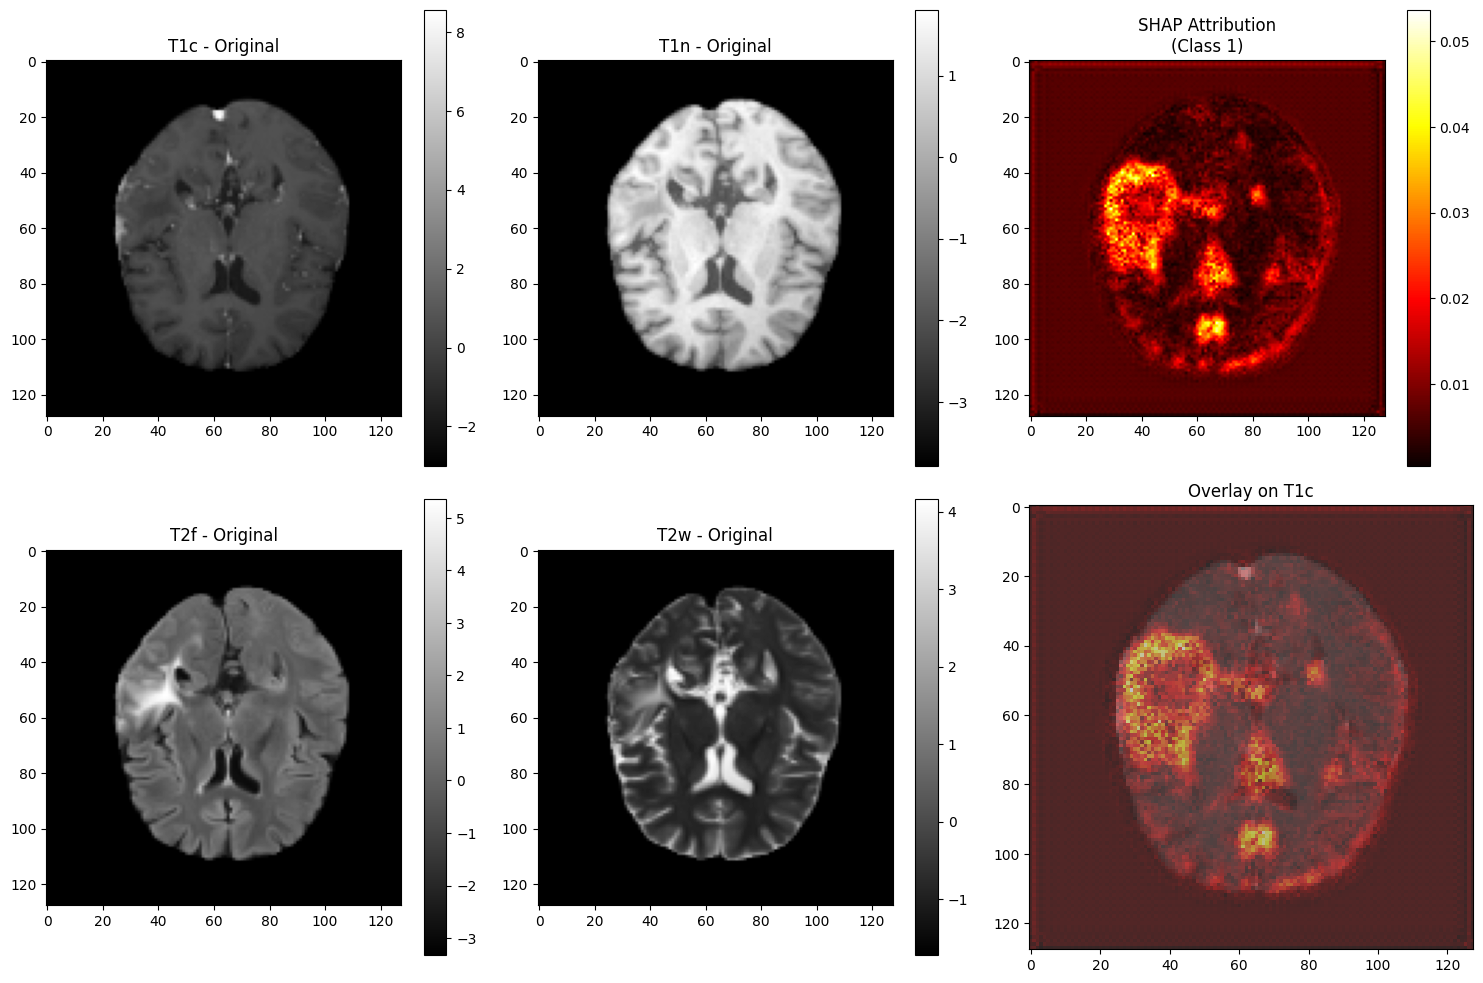

Generating LIME explanation...


  0%|          | 0/50 [00:00<?, ?it/s]

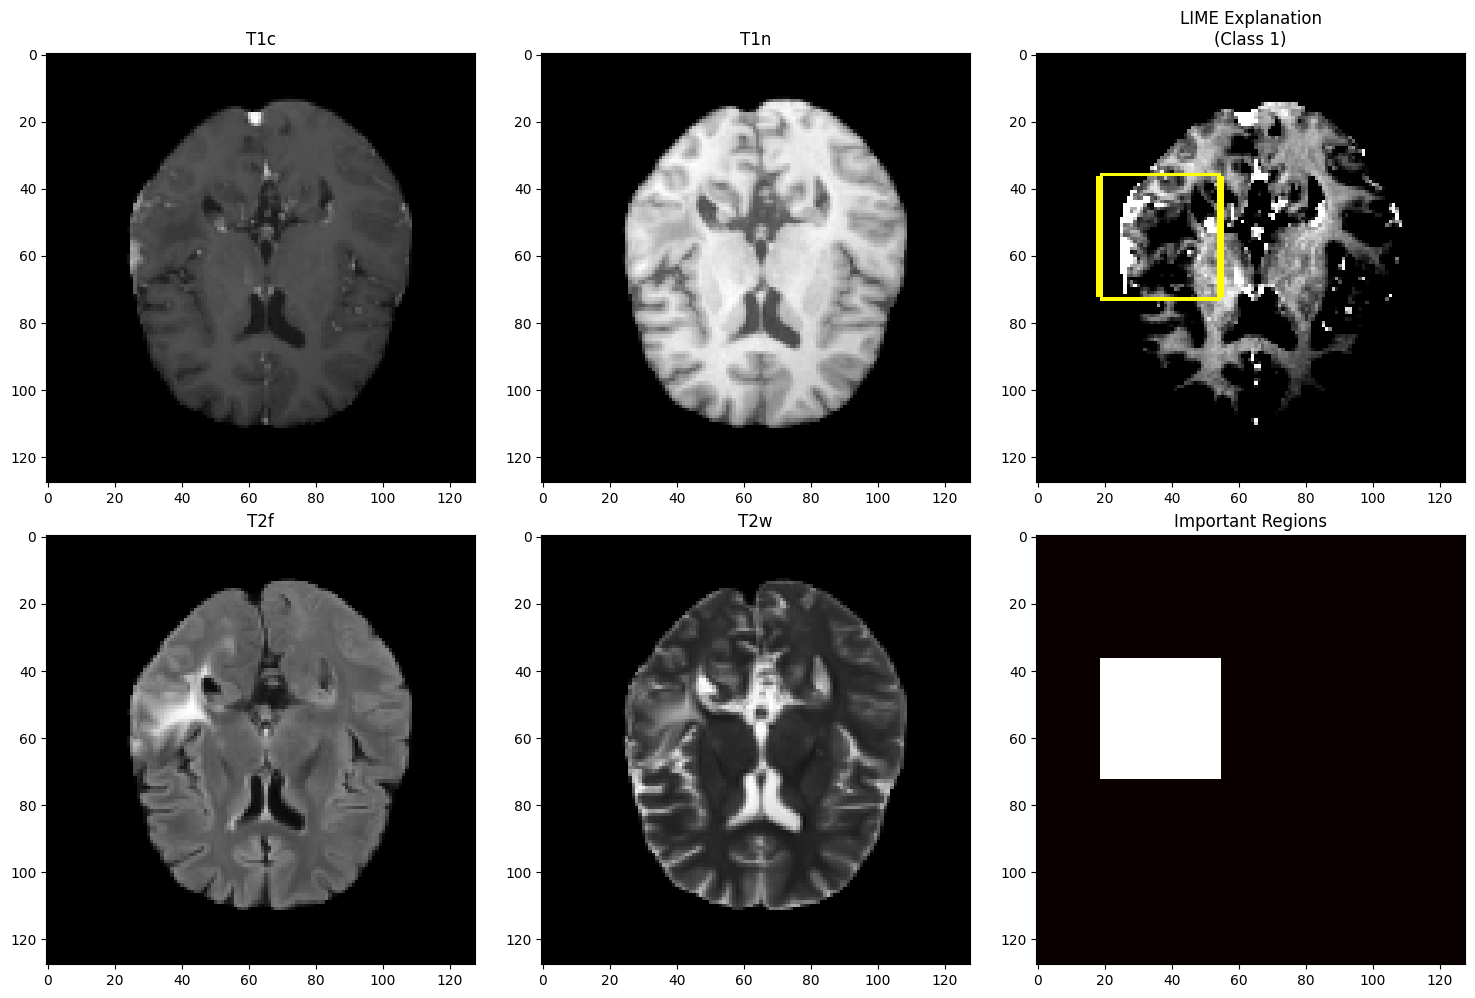


Explanations saved!
- SHAP: shap_explanation.png
- LIME: lime_explanation.png


In [10]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# SHAP and LIME imports
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ---------------------------
# 1) Dataset with light augmentation + normalization
# ---------------------------
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(32,128,128), augment=False):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        mask = vol > 0
        if mask.sum() == 0: return vol
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)

    def _augment(self, img, seg):
        if random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
            seg = np.flip(seg, axis=1).copy()
        k = random.randint(0, 3)
        img = np.rot90(img, k, axes=(2,3)).copy()
        seg = np.rot90(seg, k, axes=(1,2)).copy()
        return img, seg

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = self._zscore_mod(img)
            img = np.transpose(img, (2, 0, 1))
            mods.append(img)
        img = np.stack(mods, axis=0)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))

        if self.augment:
            img, seg = self._augment(img, seg)

        img_t = torch.from_numpy(img).unsqueeze(0)
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)
        img_t = F.interpolate(img_t, size=self.target_size, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=self.target_size, mode="nearest").long()
        return img_t.squeeze(0), seg_t.squeeze(0).squeeze(0)


# ---------------------------
# 2) 3D UNet + Transformer
# ---------------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)


class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B,C,D,H,W = x.shape
        x_flat = x.view(B, C, -1).permute(0,2,1)
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0,2,1).view(B,C,D,H,W)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ---------------------------
# 3) Loss functions
# ---------------------------
def classwise_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    one_hot = F.one_hot(targets, num_classes).permute(0,4,1,2,3).float()
    dims = (0,2,3,4)
    intersection = torch.sum(probs * one_hot, dims)
    union = torch.sum(probs + one_hot, dims)
    dice = (2*intersection + eps)/(union + eps)
    loss = 1 - dice
    return loss.mean()

def weighted_loss(logits, targets, class_weights):
    ce = F.cross_entropy(logits, targets, weight=class_weights)
    dice = classwise_dice_loss(logits, targets, num_classes=len(class_weights))
    return 0.6*ce + 0.4*dice


# ---------------------------
# 4) Dice coefficient
# ---------------------------
def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for cls in range(num_classes):
        pred_cls = (preds==cls).float()
        target_cls = (targets==cls).float()
        inter = (pred_cls*target_cls).sum(dim=(1,2,3))
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter+eps)/(union+eps)).cpu().numpy()
        per_class.append(dice)
    return float(np.mean(np.stack(per_class,axis=0).mean(axis=0)))


# ---------------------------
# 5) SHAP Implementation for 3D Medical Images
# ---------------------------
class SHAPExplainer3D:
    def __init__(self, model, device, background_samples=5):
        self.model = model
        self.device = device
        self.background_samples = background_samples
        
    def create_background(self, dataset, num_samples=None):
        """Create background dataset for SHAP"""
        if num_samples is None:
            num_samples = self.background_samples
        
        indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
        backgrounds = []
        for idx in indices:
            img, _ = dataset[idx]
            backgrounds.append(img.unsqueeze(0))
        return torch.cat(backgrounds, dim=0).to(self.device)
    
    def predict_wrapper(self, x):
        """Wrapper for model prediction"""
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
        x = x.to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            probs = torch.softmax(logits, dim=1)
        return probs.cpu().numpy()
    
    def explain_slice(self, image_3d, slice_idx, target_class=1, slice_thickness=8):
        """
        Explain a specific slice using GradientExplainer
        image_3d: (C, D, H, W) tensor
        slice_idx: which depth slice to explain
        target_class: which class to explain (0=background, 1,2,3=tumor regions)
        slice_thickness: number of slices to use (minimum 8 for pooling layers)
        """
        # Extract slice with thickness to avoid pooling issues
        start_idx = max(0, slice_idx - slice_thickness//2)
        end_idx = min(image_3d.shape[1], slice_idx + slice_thickness//2)
        
        # Ensure we have at least slice_thickness slices
        if end_idx - start_idx < slice_thickness:
            end_idx = min(image_3d.shape[1], start_idx + slice_thickness)
            if end_idx - start_idx < slice_thickness:
                start_idx = max(0, end_idx - slice_thickness)
        
        image_slice = image_3d[:, start_idx:end_idx, :, :].unsqueeze(0).to(self.device)
        image_slice.requires_grad = True
        
        # Use gradient-based explanation
        self.model.eval()
        logits = self.model(image_slice)
        
        # Get gradients for target class
        self.model.zero_grad()
        target = logits[:, target_class, :, :, :]
        target.sum().backward()
        
        # Get gradient magnitude as attribution
        gradients = image_slice.grad.abs()
        
        # Extract the center slice from gradients
        center_offset = slice_idx - start_idx
        attributions = gradients[0, :, center_offset, :, :].cpu().numpy()
        
        return attributions
    
    def visualize_shap(self, image_3d, slice_idx, target_class=1, save_path=None):
        """Visualize SHAP explanations"""
        attributions = self.explain_slice(image_3d, slice_idx, target_class)
        
        # Get the actual slice for visualization
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Plot each modality with its attribution
        modalities = ['T1c', 'T1n', 'T2f', 'T2w']
        for i in range(4):
            row = i // 2
            col = i % 2
            
            # Original image
            im = axes[row, col].imshow(img_slice[i], cmap='gray')
            axes[row, col].set_title(f'{modalities[i]} - Original')
            plt.colorbar(im, ax=axes[row, col])
        
        # Attribution heatmap (average across channels)
        attr_avg = np.mean(attributions, axis=0)
        im = axes[0, 2].imshow(attr_avg, cmap='hot')
        axes[0, 2].set_title(f'SHAP Attribution\n(Class {target_class})')
        plt.colorbar(im, ax=axes[0, 2])
        
        # Overlay on first modality
        axes[1, 2].imshow(img_slice[0], cmap='gray', alpha=0.7)
        axes[1, 2].imshow(attr_avg, cmap='hot', alpha=0.5)
        axes[1, 2].set_title('Overlay on T1c')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# ---------------------------
# 6) LIME Implementation for 3D Medical Images
# ---------------------------
class LIMEExplainer3D:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def predict_fn_2d(self, images_2d, depth_context, slice_idx):
        """
        Prediction function for LIME
        images_2d: (N, H, W, C) numpy array - LIME format
        depth_context: the full 3D context
        slice_idx: center slice index
        """
        predictions = []
        slice_thickness = 8
        
        for img_2d in images_2d:
            # img_2d is (H, W, C) where C=4 (modalities)
            img_2d = img_2d.transpose(2, 0, 1)  # (C, H, W)
            
            # Create thick slice by replacing slices around center
            start_idx = max(0, slice_idx - slice_thickness//2)
            end_idx = min(depth_context.shape[1], slice_idx + slice_thickness//2)
            
            # Ensure we have at least slice_thickness slices
            if end_idx - start_idx < slice_thickness:
                end_idx = min(depth_context.shape[1], start_idx + slice_thickness)
                if end_idx - start_idx < slice_thickness:
                    start_idx = max(0, end_idx - slice_thickness)
            
            # Create volume with perturbed slice
            img_3d = depth_context.clone()
            center_offset = slice_idx - start_idx
            img_3d[:, start_idx:end_idx, :, :] = torch.FloatTensor(
                np.tile(img_2d[:, np.newaxis, :, :], (1, end_idx-start_idx, 1, 1))
            )
            
            # Convert to tensor
            img_tensor = img_3d.unsqueeze(0).to(self.device)
            
            self.model.eval()
            with torch.no_grad():
                logits = self.model(img_tensor)
                probs = torch.softmax(logits, dim=1)
                # Average across spatial dimensions
                probs_avg = probs.mean(dim=(2, 3, 4)).cpu().numpy()[0]
            
            predictions.append(probs_avg)
        
        return np.array(predictions)
    
    def explain_slice(self, image_3d, slice_idx, target_class=1, num_samples=100):
        """
        Explain a slice using LIME
        image_3d: (C, D, H, W) tensor
        slice_idx: which depth slice to explain
        target_class: which class to explain
        """
        from skimage.segmentation import slic
        
        # Extract slice and convert to LIME format (H, W, C)
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        img_slice_lime = img_slice.transpose(1, 2, 0)  # (H, W, C)
        
        # Normalize to 0-1 for LIME
        img_slice_lime = (img_slice_lime - img_slice_lime.min()) / (img_slice_lime.max() - img_slice_lime.min() + 1e-8)
        
        # Custom segmentation function for 4-channel images
        def segmentation_fn(image):
            """SLIC segmentation that works with 4 channels"""
            # Use first channel for segmentation, or average if needed
            if image.ndim == 3 and image.shape[2] > 3:
                # For multi-channel medical images, use average or first channel
                image_for_seg = np.mean(image, axis=2)
            else:
                image_for_seg = image
            
            # Apply SLIC segmentation
            segments = slic(image_for_seg, n_segments=50, compactness=10, sigma=1, 
                           start_label=0, channel_axis=None)
            return segments
        
        # Create LIME explainer
        explainer = lime_image.LimeImageExplainer()
        
        # Create prediction function with slice_idx
        pred_fn = lambda x: self.predict_fn_2d(x, image_3d, slice_idx)
        
        # Generate explanation with custom segmentation
        explanation = explainer.explain_instance(
            img_slice_lime,
            pred_fn,
            top_labels=4,
            hide_color=0,
            num_samples=num_samples,
            batch_size=10,
            segmentation_fn=segmentation_fn
        )
        
        return explanation
    
    def visualize_lime(self, image_3d, slice_idx, target_class=1, num_samples=100, save_path=None):
        """Visualize LIME explanations"""
        explanation = self.explain_slice(image_3d, slice_idx, target_class, num_samples)
        
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        img_slice_lime = img_slice.transpose(1, 2, 0)
        img_slice_lime = (img_slice_lime - img_slice_lime.min()) / (img_slice_lime.max() - img_slice_lime.min() + 1e-8)
        
        # Get mask for positive and negative features
        temp, mask = explanation.get_image_and_mask(
            target_class, 
            positive_only=True, 
            num_features=10,
            hide_rest=False
        )
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Original modalities
        modalities = ['T1c', 'T1n', 'T2f', 'T2w']
        for i in range(4):
            row = i // 2
            col = i % 2
            axes[row, col].imshow(img_slice[i], cmap='gray')
            axes[row, col].set_title(f'{modalities[i]}')
        
        # LIME explanation - use first channel (T1c) as base for RGB conversion
        base_img = img_slice[0]  # Use T1c
        base_img_rgb = np.stack([base_img, base_img, base_img], axis=-1)  # Convert to RGB
        axes[0, 2].imshow(mark_boundaries(base_img_rgb, mask))
        axes[0, 2].set_title(f'LIME Explanation\n(Class {target_class})')
        
        # Mask only
        axes[1, 2].imshow(mask, cmap='hot')
        axes[1, 2].set_title('Important Regions')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# ---------------------------
# 7) Training Setup
# ---------------------------
def setup_training():
    root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
    patient_dirs = [os.path.join(root_dir,p) for p in os.listdir(root_dir) 
                    if os.path.isdir(os.path.join(root_dir,p))]

    dataset = BraTSDataset3D(patient_dirs, augment=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet3DTransformer().to(device)

    class_weights = torch.tensor([0.2, 1.0, 1.0, 1.2]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
    scaler = torch.amp.GradScaler('cuda')

    return {
        'model': model,
        'device': device,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'scaler': scaler,
        'class_weights': class_weights,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset
    }


# ---------------------------
# 8) Training Loop
# ---------------------------
def train_model(config, epochs=1):
    model = config['model']
    device = config['device']
    train_loader = config['train_loader']
    val_loader = config['val_loader']
    optimizer = config['optimizer']
    scheduler = config['scheduler']
    scaler = config['scaler']
    class_weights = config['class_weights']
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, segs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, segs = imgs.to(device), segs.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                logits = model(imgs)
                loss = weighted_loss(logits, segs, class_weights)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        avg_train = total_loss / len(train_loader)

        model.eval()
        val_loss, val_dice = 0, 0
        with torch.no_grad():
            for imgs, segs in tqdm(val_loader, desc="Validating"):
                imgs, segs = imgs.to(device), segs.to(device)
                with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                    logits = model(imgs)
                    loss = weighted_loss(logits, segs, class_weights)
                val_loss += loss.item()
                val_dice += dice_coefficient(logits, segs)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        print(f"Epoch {epoch+1}: Train={avg_train:.4f} | Val={avg_val_loss:.4f} | Dice={avg_val_dice:.4f}")
        scheduler.step(avg_val_loss)
        torch.cuda.empty_cache()
    
    return model


# ---------------------------
# 9) Main Execution with Explainability
# ---------------------------
def main():
    # Setup and train
    print("Setting up training...")
    config = setup_training()
    
    print("\nTraining model...")
    trained_model = train_model(config, epochs=1)
    
    # Save model
    torch.save(trained_model.state_dict(), 'unet3d_transformer_brats.pth')
    print("\nModel saved!")
    
    # Initialize explainers
    print("\nInitializing explainability tools...")
    shap_explainer = SHAPExplainer3D(trained_model, config['device'])
    lime_explainer = LIMEExplainer3D(trained_model, config['device'])
    
    # Get a sample for explanation
    print("\nGenerating explanations for a sample...")
    sample_img, sample_seg = config['val_dataset'][0]
    
    # Choose middle slice
    slice_idx = sample_img.shape[1] // 2
    
    # SHAP explanation
    print("Generating SHAP explanation...")
    shap_explainer.visualize_shap(
        sample_img, 
        slice_idx, 
        target_class=1,
        save_path='shap_explanation.png'
    )
    
    # LIME explanation
    print("Generating LIME explanation...")
    lime_explainer.visualize_lime(
        sample_img,
        slice_idx,
        target_class=1,
        num_samples=50,
        save_path='lime_explanation.png'
    )
    
    print("\nExplanations saved!")
    print("- SHAP: shap_explanation.png")
    print("- LIME: lime_explanation.png")
    
    return trained_model, shap_explainer, lime_explainer


# Run the complete pipeline
if __name__ == "__main__":
    model, shap_exp, lime_exp = main()

Setting up training...

Training model...


Validating: 100%|██████████| 40/40 [00:48<00:00,  1.21s/it]


Epoch 1: Train=0.6408 | Val=0.5348 | Dice=0.7003

Model saved!

Initializing explainability tools...

Generating explanations for a sample...
Generating SHAP explanation...


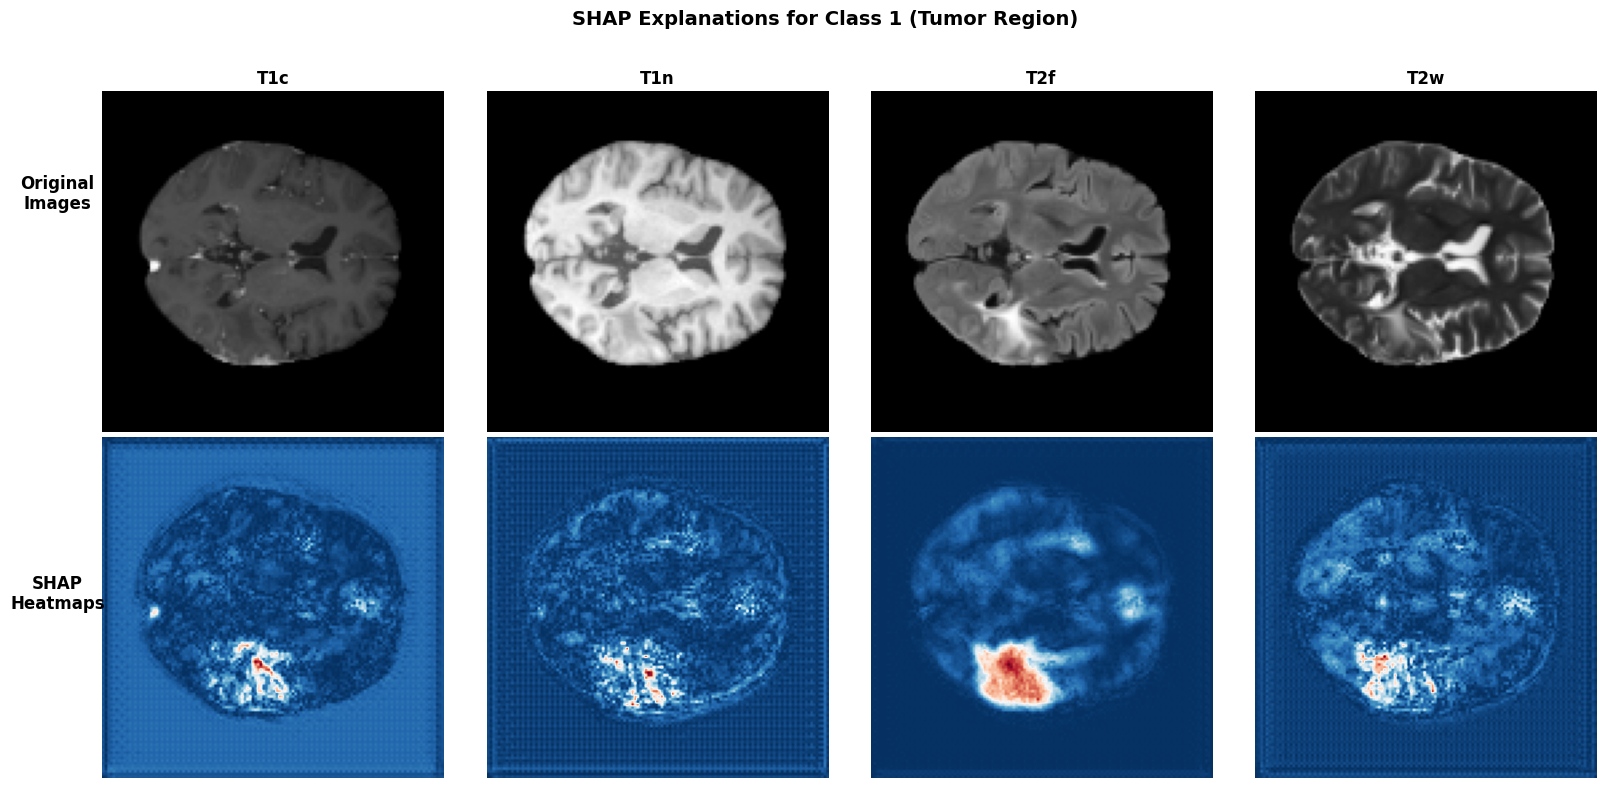

Generating LIME explanation...


  0%|          | 0/50 [00:00<?, ?it/s]

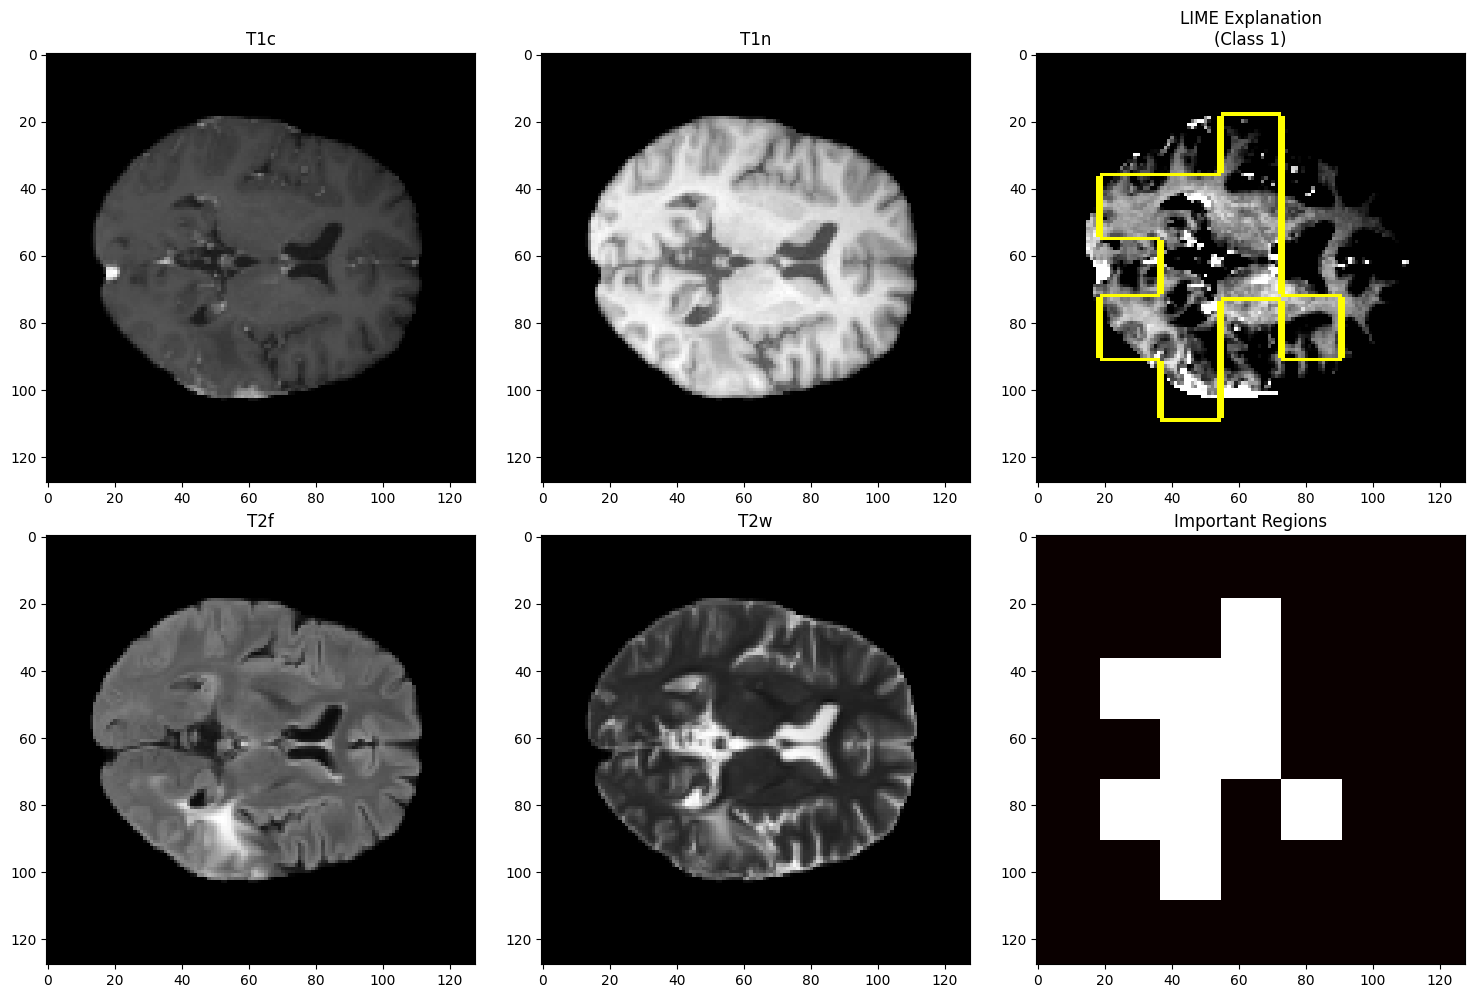


Explanations saved!
- SHAP: shap_explanation.png
- LIME: lime_explanation.png


In [11]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# SHAP and LIME imports
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# ---------------------------
# 1) Dataset with light augmentation + normalization
# ---------------------------
class BraTSDataset3D(Dataset):
    def __init__(self, patient_dirs, target_size=(32,128,128), augment=False):
        self.patient_dirs = patient_dirs
        self.target_size = target_size
        self.mods = ["t1c", "t1n", "t2f", "t2w"]
        self.augment = augment

    def __len__(self):
        return len(self.patient_dirs)

    def _zscore_mod(self, vol):
        mask = vol > 0
        if mask.sum() == 0: return vol
        v = vol[mask]
        return (vol - v.mean()) / (v.std() + 1e-8)

    def _augment(self, img, seg):
        if random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
            seg = np.flip(seg, axis=1).copy()
        k = random.randint(0, 3)
        img = np.rot90(img, k, axes=(2,3)).copy()
        seg = np.rot90(seg, k, axes=(1,2)).copy()
        return img, seg

    def __getitem__(self, idx):
        pdir = self.patient_dirs[idx]
        pid = os.path.basename(pdir)

        mods = []
        for m in self.mods:
            img_path = os.path.join(pdir, f"{pid}-{m}.nii")
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = self._zscore_mod(img)
            img = np.transpose(img, (2, 0, 1))
            mods.append(img)
        img = np.stack(mods, axis=0)

        seg_path = os.path.join(pdir, f"{pid}-seg.nii")
        seg = nib.load(seg_path).get_fdata().astype(np.int64)
        seg[seg == 4] = 3
        seg = np.transpose(seg, (2, 0, 1))

        if self.augment:
            img, seg = self._augment(img, seg)

        img_t = torch.from_numpy(img).unsqueeze(0)
        seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)
        img_t = F.interpolate(img_t, size=self.target_size, mode="trilinear", align_corners=False)
        seg_t = F.interpolate(seg_t.float(), size=self.target_size, mode="nearest").long()
        return img_t.squeeze(0), seg_t.squeeze(0).squeeze(0)


# ---------------------------
# 2) 3D UNet + Transformer
# ---------------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)


class TransformerBlock3D(nn.Module):
    def __init__(self, dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B,C,D,H,W = x.shape
        x_flat = x.view(B, C, -1).permute(0,2,1)
        x_norm = self.norm1(x_flat)
        attn_out = self.attn(x_norm, x_norm, x_norm)[0]
        x = x_flat + attn_out
        x = x + self.ffn(self.norm2(x))
        return x.permute(0,2,1).view(B,C,D,H,W)


class UNet3DTransformer(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.pool = nn.MaxPool3d(2)
        self.trans = TransformerBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.trans(e3)
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)


# ---------------------------
# 3) Loss functions
# ---------------------------
def classwise_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    one_hot = F.one_hot(targets, num_classes).permute(0,4,1,2,3).float()
    dims = (0,2,3,4)
    intersection = torch.sum(probs * one_hot, dims)
    union = torch.sum(probs + one_hot, dims)
    dice = (2*intersection + eps)/(union + eps)
    loss = 1 - dice
    return loss.mean()

def weighted_loss(logits, targets, class_weights):
    ce = F.cross_entropy(logits, targets, weight=class_weights)
    dice = classwise_dice_loss(logits, targets, num_classes=len(class_weights))
    return 0.6*ce + 0.4*dice


# ---------------------------
# 4) Dice coefficient
# ---------------------------
def dice_coefficient(logits, targets, num_classes=4, eps=1e-6):
    preds = torch.argmax(logits, dim=1)
    per_class = []
    for cls in range(num_classes):
        pred_cls = (preds==cls).float()
        target_cls = (targets==cls).float()
        inter = (pred_cls*target_cls).sum(dim=(1,2,3))
        union = pred_cls.sum(dim=(1,2,3)) + target_cls.sum(dim=(1,2,3))
        dice = ((2*inter+eps)/(union+eps)).cpu().numpy()
        per_class.append(dice)
    return float(np.mean(np.stack(per_class,axis=0).mean(axis=0)))


# ---------------------------
# 5) SHAP Implementation for 3D Medical Images
# ---------------------------
class SHAPExplainer3D:
    def __init__(self, model, device, background_samples=5):
        self.model = model
        self.device = device
        self.background_samples = background_samples
        
    def create_background(self, dataset, num_samples=None):
        """Create background dataset for SHAP"""
        if num_samples is None:
            num_samples = self.background_samples
        
        indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
        backgrounds = []
        for idx in indices:
            img, _ = dataset[idx]
            backgrounds.append(img.unsqueeze(0))
        return torch.cat(backgrounds, dim=0).to(self.device)
    
    def predict_wrapper(self, x):
        """Wrapper for model prediction"""
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
        x = x.to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            logits = self.model(x)
            probs = torch.softmax(logits, dim=1)
        return probs.cpu().numpy()
    
    def explain_slice(self, image_3d, slice_idx, target_class=1, slice_thickness=8):
        """
        Explain a specific slice using GradientExplainer
        image_3d: (C, D, H, W) tensor
        slice_idx: which depth slice to explain
        target_class: which class to explain (0=background, 1,2,3=tumor regions)
        slice_thickness: number of slices to use (minimum 8 for pooling layers)
        """
        # Extract slice with thickness to avoid pooling issues
        start_idx = max(0, slice_idx - slice_thickness//2)
        end_idx = min(image_3d.shape[1], slice_idx + slice_thickness//2)
        
        # Ensure we have at least slice_thickness slices
        if end_idx - start_idx < slice_thickness:
            end_idx = min(image_3d.shape[1], start_idx + slice_thickness)
            if end_idx - start_idx < slice_thickness:
                start_idx = max(0, end_idx - slice_thickness)
        
        image_slice = image_3d[:, start_idx:end_idx, :, :].unsqueeze(0).to(self.device)
        image_slice.requires_grad = True
        
        # Use gradient-based explanation
        self.model.eval()
        logits = self.model(image_slice)
        
        # Get gradients for target class
        self.model.zero_grad()
        target = logits[:, target_class, :, :, :]
        target.sum().backward()
        
        # Get gradient magnitude as attribution
        gradients = image_slice.grad.abs()
        
        # Extract the center slice from gradients
        center_offset = slice_idx - start_idx
        attributions = gradients[0, :, center_offset, :, :].cpu().numpy()
        
        return attributions
    
    def visualize_shap(self, image_3d, slice_idx, target_class=1, save_path=None):
        """Visualize SHAP explanations in grid format"""
        attributions = self.explain_slice(image_3d, slice_idx, target_class)
        
        # Get the actual slice for visualization
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        
        # Create 2x4 grid: top row = original images, bottom row = SHAP heatmaps
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        modalities = ['T1c', 'T1n', 'T2f', 'T2w']
        
        for i in range(4):
            # Top row: Original images in grayscale
            axes[0, i].imshow(img_slice[i], cmap='gray')
            axes[0, i].set_title(f'{modalities[i]}', fontsize=12, fontweight='bold')
            axes[0, i].axis('off')
            
            # Bottom row: SHAP attribution heatmaps (red-blue colormap)
            # Normalize attribution for this modality
            attr = attributions[i]
            attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
            
            # Use RdBu_r colormap (red for high importance, blue for low)
            im = axes[1, i].imshow(attr_norm, cmap='RdBu_r', vmin=0, vmax=1)
            axes[1, i].axis('off')
        
        # Add overall title
        fig.suptitle(f'SHAP Explanations for Class {target_class} (Tumor Region)', 
                     fontsize=14, fontweight='bold', y=0.98)
        
        # Add row labels
        fig.text(0.02, 0.75, 'Original\nImages', fontsize=12, fontweight='bold', 
                 va='center', ha='center', rotation=0)
        fig.text(0.02, 0.25, 'SHAP\nHeatmaps', fontsize=12, fontweight='bold', 
                 va='center', ha='center', rotation=0)
        
        plt.tight_layout(rect=[0.03, 0, 1, 0.96])
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()


# ---------------------------
# 6) LIME Implementation for 3D Medical Images
# ---------------------------
class LIMEExplainer3D:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def predict_fn_2d(self, images_2d, depth_context, slice_idx):
        """
        Prediction function for LIME
        images_2d: (N, H, W, C) numpy array - LIME format
        depth_context: the full 3D context
        slice_idx: center slice index
        """
        predictions = []
        slice_thickness = 8
        
        for img_2d in images_2d:
            # img_2d is (H, W, C) where C=4 (modalities)
            img_2d = img_2d.transpose(2, 0, 1)  # (C, H, W)
            
            # Create thick slice by replacing slices around center
            start_idx = max(0, slice_idx - slice_thickness//2)
            end_idx = min(depth_context.shape[1], slice_idx + slice_thickness//2)
            
            # Ensure we have at least slice_thickness slices
            if end_idx - start_idx < slice_thickness:
                end_idx = min(depth_context.shape[1], start_idx + slice_thickness)
                if end_idx - start_idx < slice_thickness:
                    start_idx = max(0, end_idx - slice_thickness)
            
            # Create volume with perturbed slice
            img_3d = depth_context.clone()
            center_offset = slice_idx - start_idx
            img_3d[:, start_idx:end_idx, :, :] = torch.FloatTensor(
                np.tile(img_2d[:, np.newaxis, :, :], (1, end_idx-start_idx, 1, 1))
            )
            
            # Convert to tensor
            img_tensor = img_3d.unsqueeze(0).to(self.device)
            
            self.model.eval()
            with torch.no_grad():
                logits = self.model(img_tensor)
                probs = torch.softmax(logits, dim=1)
                # Average across spatial dimensions
                probs_avg = probs.mean(dim=(2, 3, 4)).cpu().numpy()[0]
            
            predictions.append(probs_avg)
        
        return np.array(predictions)
    
    def explain_slice(self, image_3d, slice_idx, target_class=1, num_samples=100):
        """
        Explain a slice using LIME
        image_3d: (C, D, H, W) tensor
        slice_idx: which depth slice to explain
        target_class: which class to explain
        """
        from skimage.segmentation import slic
        
        # Extract slice and convert to LIME format (H, W, C)
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        img_slice_lime = img_slice.transpose(1, 2, 0)  # (H, W, C)
        
        # Normalize to 0-1 for LIME
        img_slice_lime = (img_slice_lime - img_slice_lime.min()) / (img_slice_lime.max() - img_slice_lime.min() + 1e-8)
        
        # Custom segmentation function for 4-channel images
        def segmentation_fn(image):
            """SLIC segmentation that works with 4 channels"""
            # Use first channel for segmentation, or average if needed
            if image.ndim == 3 and image.shape[2] > 3:
                # For multi-channel medical images, use average or first channel
                image_for_seg = np.mean(image, axis=2)
            else:
                image_for_seg = image
            
            # Apply SLIC segmentation
            segments = slic(image_for_seg, n_segments=50, compactness=10, sigma=1, 
                           start_label=0, channel_axis=None)
            return segments
        
        # Create LIME explainer
        explainer = lime_image.LimeImageExplainer()
        
        # Create prediction function with slice_idx
        pred_fn = lambda x: self.predict_fn_2d(x, image_3d, slice_idx)
        
        # Generate explanation with custom segmentation
        explanation = explainer.explain_instance(
            img_slice_lime,
            pred_fn,
            top_labels=4,
            hide_color=0,
            num_samples=num_samples,
            batch_size=10,
            segmentation_fn=segmentation_fn
        )
        
        return explanation
    
    def visualize_lime(self, image_3d, slice_idx, target_class=1, num_samples=100, save_path=None):
        """Visualize LIME explanations"""
        explanation = self.explain_slice(image_3d, slice_idx, target_class, num_samples)
        
        img_slice = image_3d[:, slice_idx, :, :].cpu().numpy()
        img_slice_lime = img_slice.transpose(1, 2, 0)
        img_slice_lime = (img_slice_lime - img_slice_lime.min()) / (img_slice_lime.max() - img_slice_lime.min() + 1e-8)
        
        # Get mask for positive and negative features
        temp, mask = explanation.get_image_and_mask(
            target_class, 
            positive_only=True, 
            num_features=10,
            hide_rest=False
        )
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Original modalities
        modalities = ['T1c', 'T1n', 'T2f', 'T2w']
        for i in range(4):
            row = i // 2
            col = i % 2
            axes[row, col].imshow(img_slice[i], cmap='gray')
            axes[row, col].set_title(f'{modalities[i]}')
        
        # LIME explanation - use first channel (T1c) as base for RGB conversion
        base_img = img_slice[0]  # Use T1c
        base_img_rgb = np.stack([base_img, base_img, base_img], axis=-1)  # Convert to RGB
        axes[0, 2].imshow(mark_boundaries(base_img_rgb, mask))
        axes[0, 2].set_title(f'LIME Explanation\n(Class {target_class})')
        
        # Mask only
        axes[1, 2].imshow(mask, cmap='hot')
        axes[1, 2].set_title('Important Regions')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# ---------------------------
# 7) Training Setup
# ---------------------------
def setup_training():
    root_dir = "/kaggle/input/brats2024-small-dataset/BraTS2024_small_dataset"
    patient_dirs = [os.path.join(root_dir,p) for p in os.listdir(root_dir) 
                    if os.path.isdir(os.path.join(root_dir,p))]

    dataset = BraTSDataset3D(patient_dirs, augment=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet3DTransformer().to(device)

    class_weights = torch.tensor([0.2, 1.0, 1.0, 1.2]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
    scaler = torch.amp.GradScaler('cuda')

    return {
        'model': model,
        'device': device,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'scaler': scaler,
        'class_weights': class_weights,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset
    }


# ---------------------------
# 8) Training Loop
# ---------------------------
def train_model(config, epochs=1):
    model = config['model']
    device = config['device']
    train_loader = config['train_loader']
    val_loader = config['val_loader']
    optimizer = config['optimizer']
    scheduler = config['scheduler']
    scaler = config['scaler']
    class_weights = config['class_weights']
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, segs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, segs = imgs.to(device), segs.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                logits = model(imgs)
                loss = weighted_loss(logits, segs, class_weights)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        avg_train = total_loss / len(train_loader)

        model.eval()
        val_loss, val_dice = 0, 0
        with torch.no_grad():
            for imgs, segs in tqdm(val_loader, desc="Validating"):
                imgs, segs = imgs.to(device), segs.to(device)
                with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else 'cpu'):
                    logits = model(imgs)
                    loss = weighted_loss(logits, segs, class_weights)
                val_loss += loss.item()
                val_dice += dice_coefficient(logits, segs)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        print(f"Epoch {epoch+1}: Train={avg_train:.4f} | Val={avg_val_loss:.4f} | Dice={avg_val_dice:.4f}")
        scheduler.step(avg_val_loss)
        torch.cuda.empty_cache()
    
    return model


# ---------------------------
# 9) Main Execution with Explainability
# ---------------------------
def main():
    # Setup and train
    print("Setting up training...")
    config = setup_training()
    
    print("\nTraining model...")
    trained_model = train_model(config, epochs=1)
    
    # Save model
    torch.save(trained_model.state_dict(), 'unet3d_transformer_brats.pth')
    print("\nModel saved!")
    
    # Initialize explainers
    print("\nInitializing explainability tools...")
    shap_explainer = SHAPExplainer3D(trained_model, config['device'])
    lime_explainer = LIMEExplainer3D(trained_model, config['device'])
    
    # Get a sample for explanation
    print("\nGenerating explanations for a sample...")
    sample_img, sample_seg = config['val_dataset'][0]
    
    # Choose middle slice
    slice_idx = sample_img.shape[1] // 2
    
    # SHAP explanation
    print("Generating SHAP explanation...")
    shap_explainer.visualize_shap(
        sample_img, 
        slice_idx, 
        target_class=1,
        save_path='shap_explanation.png'
    )
    
    # LIME explanation
    print("Generating LIME explanation...")
    lime_explainer.visualize_lime(
        sample_img,
        slice_idx,
        target_class=1,
        num_samples=50,
        save_path='lime_explanation.png'
    )
    
    print("\nExplanations saved!")
    print("- SHAP: shap_explanation.png")
    print("- LIME: lime_explanation.png")
    
    return trained_model, shap_explainer, lime_explainer


# Run the complete pipeline
if __name__ == "__main__":
    model, shap_exp, lime_exp = main()